In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy import stats

In [79]:
df = pd.read_csv('Term_Project_Dataset_20K.csv')

In [80]:
print("\nShape of the dataset (rows, columns):", df.shape)
print("\nFirst 5 rows (df.head()):")
print(df.head())

print("\nData types and non-null counts:")
info_df = pd.DataFrame({
    'Dtype': df.dtypes,
    'Non-Null Count': df.count(),
    'Missing Values': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100
})
print(info_df)


Shape of the dataset (rows, columns): (20000, 41)

First 5 rows (df.head()):
    age  gender  parent_income  num_siblings  family_support  \
0  24.0  Female        22678.0           0.0             1.0   
1  21.0    Male        17905.0           3.0             2.0   
2  28.0    Male            NaN           0.0             0.0   
3  25.0  Female        29391.0           4.0             4.0   
4  22.0    Male        15522.0           0.0             4.0   

   commute_time_min part_time_job  previous_gpa  num_failed_courses  \
0              95.0            No          2.22                 3.0   
1               0.0           Yes          3.78                 1.0   
2              67.0            No           NaN                 4.0   
3              83.0           Yes          1.84                 4.0   
4              58.0           Yes          3.38                 0.0   

   high_school_grade  ...  concentration_level  exam_anxiety_level  \
0               99.7  ...               

In [81]:
print("\nSummary Statistics for Numerical Features:")
print(df.describe().T)


Summary Statistics for Numerical Features:
                               count          mean           std     min  \
age                          19400.0     23.478918      3.452709    18.0   
parent_income                19400.0  18290.515928  30896.118002  2000.0   
num_siblings                 19400.0      2.510361      1.715978     0.0   
family_support               19400.0      2.502680      1.707515     0.0   
commute_time_min             19400.0     59.318144     34.796772     0.0   
previous_gpa                 19400.0      2.491322      0.869089     1.0   
num_failed_courses           19400.0      1.996443      1.413680     0.0   
high_school_grade            19400.0     74.902892     14.425122    50.0   
math_background_score        19400.0     49.352577     28.890298     0.0   
language_background_score    19400.0     49.412268     28.842990     0.0   
science_background_score     19400.0     49.675155     28.870424     0.0   
prior_semester_credits       19400.0     16.

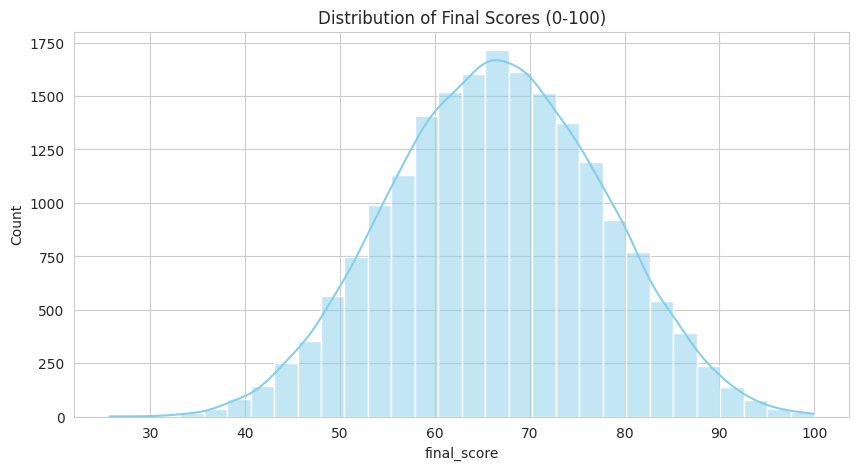

In [82]:
# Set plotting style for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# a. Distribution of Target Variables
plt.figure(figsize=(10, 5))
sns.histplot(df['final_score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Final Scores (0-100)')
plt.show()

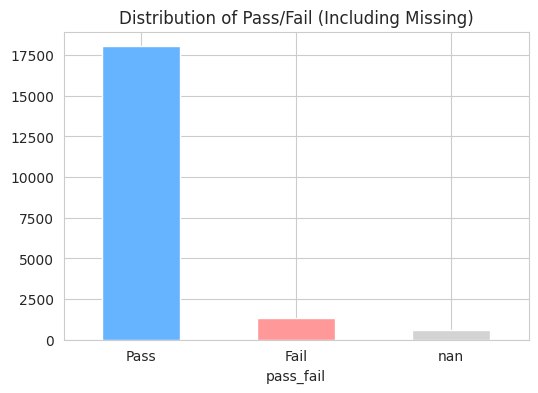

In [83]:
# Pass/Fail (Binary Target) - Highlight Class Imbalance
pass_fail_counts = df['pass_fail'].value_counts(dropna=False)
plt.figure(figsize=(6, 4))
pass_fail_counts.plot(kind='bar', color=['#66b3ff', '#ff9999', 'lightgray'])
plt.title('Distribution of Pass/Fail (Including Missing)')
plt.xticks(rotation=0)
plt.show()

In [84]:
numerical_df = df.select_dtypes(include=np.number).drop(columns=['final_score', 'final_grade', 'pass_fail'], errors='ignore')
correlation_matrix = numerical_df.corrwith(df['final_score']).sort_values(ascending=False)
print("\nTop 10 Features Most Correlated with final_score (Absolute Value):")
print(correlation_matrix.abs().sort_values(ascending=False).head(10))


Top 10 Features Most Correlated with final_score (Absolute Value):
midterm_score                 0.654454
quiz_avg_score                0.388993
assignment_submission_rate    0.318599
lecture_attendance_rate       0.301532
stress_level                  0.025407
motivation_level              0.018407
sleep_hours                   0.017131
previous_gpa                  0.015622
high_school_grade             0.014388
discussion_forum_posts        0.010706
dtype: float64


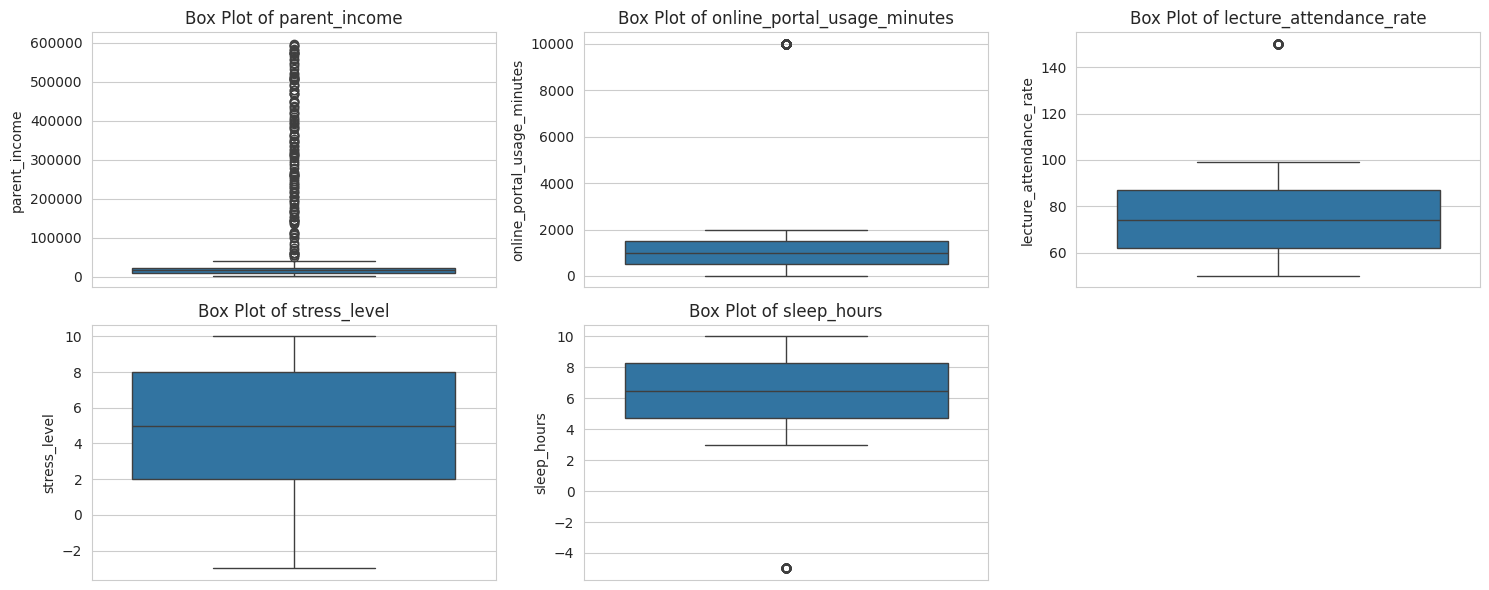

In [85]:
# c. Outlier Visualization for key features
key_numerical_cols = ['parent_income', 'online_portal_usage_minutes', 'lecture_attendance_rate', 'stress_level', 'sleep_hours']
plt.figure(figsize=(15, 6))
for i, col in enumerate(key_numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [86]:

# Identify numerical columns for outlier analysis
numerical_cols = df.select_dtypes(include=np.number).columns.drop(['final_score'], errors='ignore')
outlier_counts = {}
outlier_percentage = {}

for col in numerical_cols:
    series = df[col].dropna()

    if series.empty:
        outlier_counts[col] = 0
        outlier_percentage[col] = 0.0
        continue

    # Calculate IQR bounds
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    outlier_counts[col] = len(outliers)
    outlier_percentage[col] = (len(outliers) / len(series)) * 100

outlier_summary = pd.DataFrame({
    'Outlier Count': outlier_counts,
    'Outlier Percentage': outlier_percentage
}).sort_values(by='Outlier Count', ascending=False)

print("\nTop 10 Features with the Highest Outlier Count (for determination):")
print(outlier_summary[outlier_summary['Outlier Count'] > 0].head())


Top 10 Features with the Highest Outlier Count (for determination):
                             Outlier Count  Outlier Percentage
online_portal_usage_minutes            147            0.757732
study_hours_last_semester              144            0.742268
parent_income                          144            0.742268
sleep_hours                             79            0.407216
lecture_attendance_rate                 76            0.391753


In [87]:
# --- 3. Missing Value Handling (Imputation) ---
df_imputed = df.copy()

num_cols = df_imputed.select_dtypes(include=np.number).columns
cat_cols = df_imputed.select_dtypes(include=['object', 'category']).columns

# a. Impute Numerical Features (Median Imputation)
median_imputer = SimpleImputer(strategy='median')
df_imputed[num_cols] = median_imputer.fit_transform(df_imputed[num_cols])

# b. Impute Categorical Features (Mode Imputation)
mode_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[cat_cols] = mode_imputer.fit_transform(df_imputed[cat_cols])

In [88]:
# --- 1b. Separate Features and Targets ---
target_cols = ['final_score', 'final_grade', 'pass_fail']
X = df_imputed.drop(columns=target_cols)
y_reg = df_imputed['final_score']
y_cls = df_imputed['pass_fail']

# --- 1c. Train/Validation/Test Split (70/10/20) ---
X_train_val, X_test, y_reg_train_val, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
# Define y_cls splits for the next step
y_cls_train_val = y_cls.loc[X_train_val.index]
y_cls_test = y_cls.loc[X_test.index]

# Split 2: 70% (Train) / 10% (Validation) -> 10%/80% = 0.125 of remaining chunk
val_size_of_train_val_chunk = 0.1 / 0.8 # = 0.125
X_train, X_val, y_reg_train, y_reg_val = train_test_split(
    X_train_val, y_reg_train_val, test_size=val_size_of_train_val_chunk, random_state=42
)
# Final classification target splits
y_cls_train = y_cls_train_val.loc[X_train.index]
y_cls_val = y_cls_train_val.loc[X_val.index]

In [89]:
#Outlier Treatment (Winsorization/Capping on Training Set)
outlier_cols = ['parent_income', 'online_portal_usage_minutes', 'lecture_attendance_rate', 'stress_level', 'sleep_hours']

def winsorize_series(series, lower_percentile=1, upper_percentile=99):
    lower_bound = series.quantile(lower_percentile / 100)
    upper_bound = series.quantile(upper_percentile / 100)
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in outlier_cols:
    # Fit and apply on train
    X_train[col] = winsorize_series(X_train[col])
    # Apply train bounds to validation and test
    lower_bound = X_train[col].min()
    upper_bound = X_train[col].max()
    X_val[col] = X_val[col].clip(lower=lower_bound, upper=upper_bound)
    X_test[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped via Winsorization (1st and 99th percentiles).")

Outliers capped via Winsorization (1st and 99th percentiles).


In [90]:
#Encoding Categorical Features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_features])

def encode_data(df, encoder, cat_cols):
    encoded_features = encoder.transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded_features, index=df.index, columns=encoder.get_feature_names_out(cat_cols))
    df_encoded = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)
    return df_encoded

X_train = encode_data(X_train, encoder, categorical_features)
X_val = encode_data(X_val, encoder, categorical_features)
X_test = encode_data(X_test, encoder, categorical_features)

In [91]:
#  Feature Scaling
numerical_features = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Numerical features scaled (StandardScaler).")
print("\nPreprocessing complete. Data is ready for Model Development.")

# Save the final preprocessed datasets to CSV for future steps
X_train.to_csv('X_train_imputed_preprocessed.csv', index=False)
X_val.to_csv('X_val_imputed_preprocessed.csv', index=False)
X_test.to_csv('X_test_imputed_preprocessed.csv', index=False)
y_reg_train.to_csv('y_reg_train_imputed.csv', index=False)
y_cls_train.to_csv('y_cls_train_imputed.csv', index=False)

Numerical features scaled (StandardScaler).

Preprocessing complete. Data is ready for Model Development.


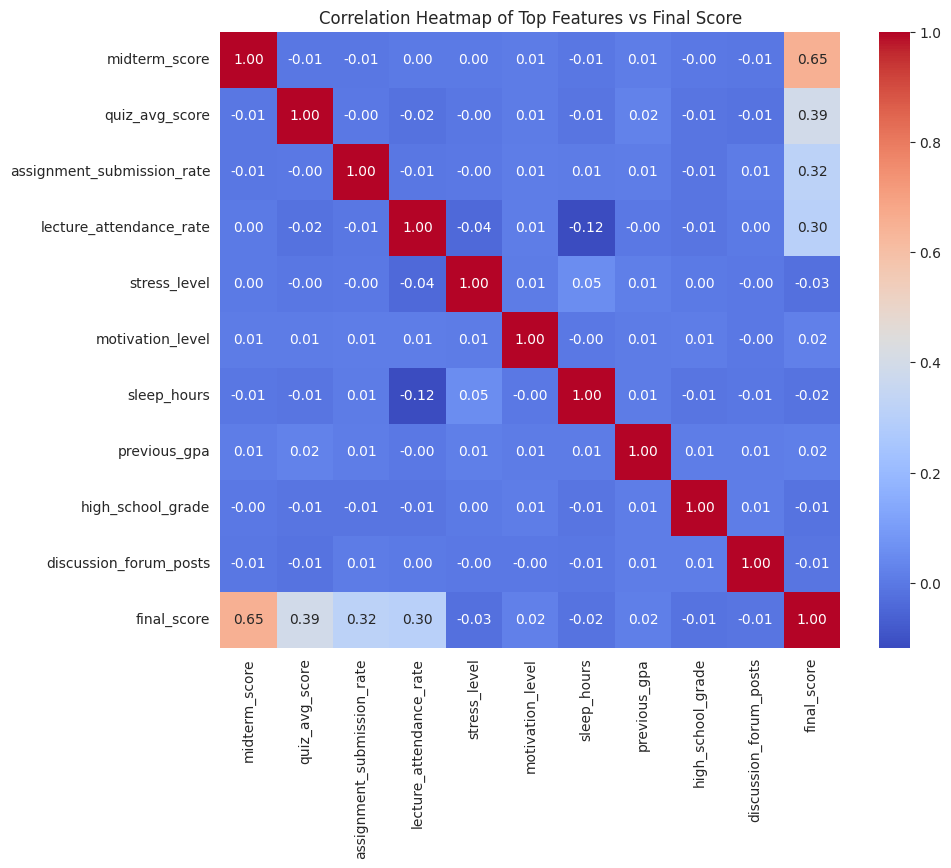

In [92]:
# Select top 10 correlated features with final_score
top_features = correlation_matrix.abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[top_features.tolist() + ['final_score']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation Heatmap of Top Features vs Final Score')
plt.show()


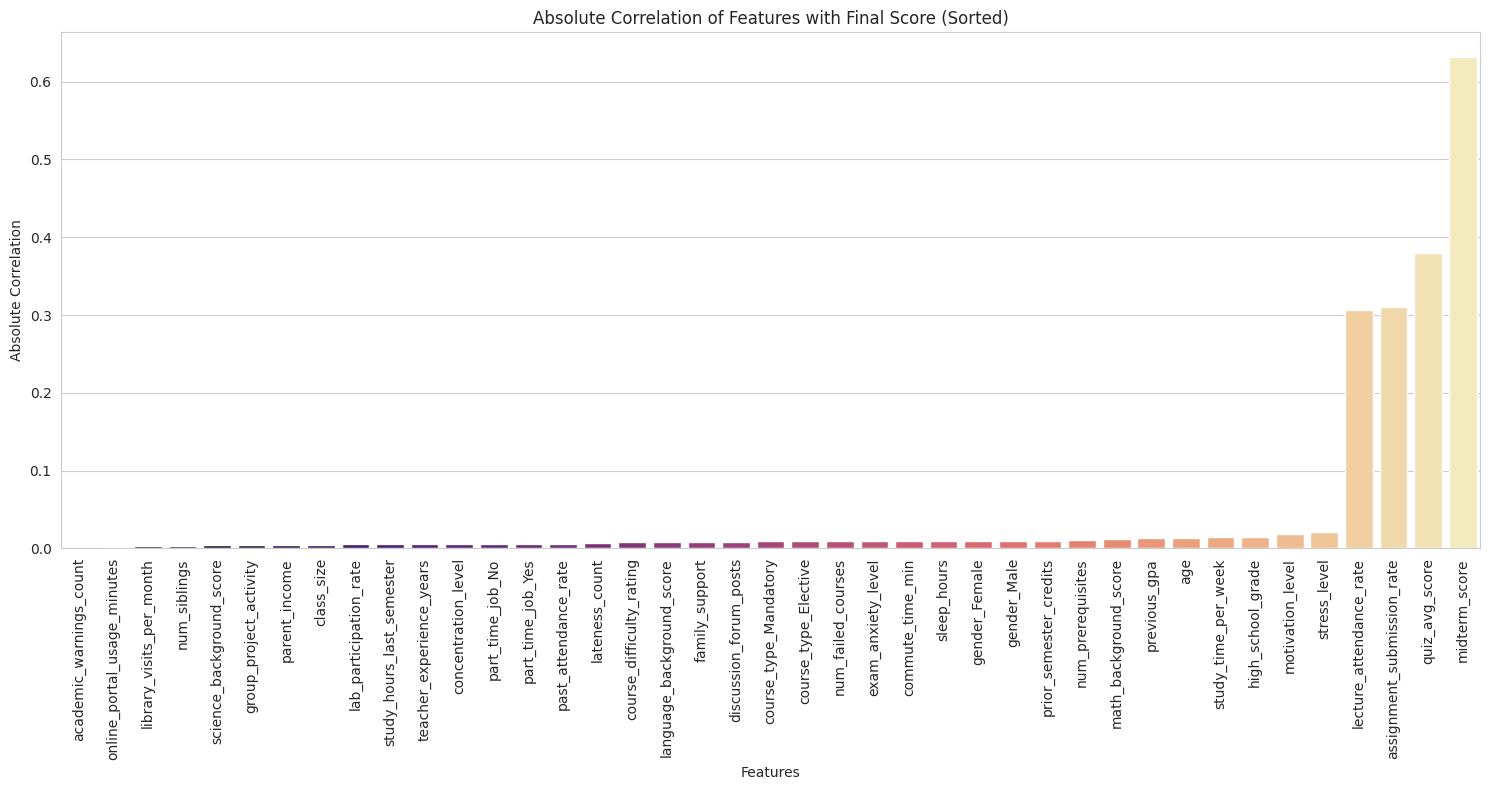

Features with the lowest absolute correlation to final_score:
academic_warnings_count        0.000321
online_portal_usage_minutes    0.001683
library_visits_per_month       0.002725
num_siblings                   0.003598
science_background_score       0.004258
group_project_activity         0.004259
parent_income                  0.004352
class_size                     0.004451
lab_participation_rate         0.005229
study_hours_last_semester      0.005313
dtype: float64


In [93]:
corr_with_target = X_train.corrwith(y_reg_train).abs().sort_values(ascending=True)

plt.figure(figsize=(15, 8))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, hue=corr_with_target.index, palette='magma', legend=False)
plt.xticks(rotation=90)
plt.title('Absolute Correlation of Features with Final Score (Sorted)')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print("Features with the lowest absolute correlation to final_score:")
print(corr_with_target.head(10))

In [94]:
# resplit the df_imputed to get an unscaled X_train
# This ensures we use the data state right after imputation but before any scaling or encoding.

target_cols = ['final_score', 'final_grade', 'pass_fail']
X_unscaled_full = df_imputed.drop(columns=target_cols)
# y_reg_full = df_imputed['final_score'] # Target not needed for X variance calculation

X_train_val_unscaled, X_test_unscaled = train_test_split(
    X_unscaled_full, test_size=0.2, random_state=42
)

val_size_of_train_val_chunk = 0.1 / 0.8
X_train_unscaled, X_val_unscaled = train_test_split(
    X_train_val_unscaled, test_size=val_size_of_train_val_chunk, random_state=42
)


numerical_cols_unscaled = X_train_unscaled.select_dtypes(include=np.number).columns

# calculate variance for numerical features in X_train_unscaled
variance_df_unscaled = pd.DataFrame(
    X_train_unscaled[numerical_cols_unscaled].var(),
    columns=['Variance']
).sort_values(by='Variance', ascending=True)



print("Features with the lowest variance:")
print(variance_df_unscaled.head(10))

print("\nFeatures with the highest variance:")
print(variance_df_unscaled.tail(10).sort_values(by='Variance', ascending=False))

Features with the lowest variance:
                          Variance
previous_gpa              0.733293
academic_warnings_count   1.222555
course_difficulty_rating  1.921558
num_failed_courses        1.936339
num_prerequisites         1.942995
family_support            2.819565
num_siblings              2.862515
sleep_hours               4.487876
prior_semester_credits    6.474819
motivation_level          9.702990

Features with the highest variance:
                                 Variance
parent_income                9.336748e+08
online_portal_usage_minutes  9.308082e+05
study_hours_last_semester    4.118020e+03
class_size                   2.619438e+03
commute_time_min             1.180341e+03
quiz_avg_score               8.124434e+02
group_project_activity       8.121640e+02
math_background_score        8.088156e+02
lab_participation_rate       8.079608e+02
science_background_score     8.064496e+02


Feature variance was analyzed on unscaled numerical training data to identify near-constant or highly dispersed features, serving as a supplementary indicator alongside correlation and outlier analysis.


Noise often manifests as extreme values that deviate significantly from the rest of the dataset. The IQR method identifies noise by focusing on the "middle 50%" of the data and flagging points that fall too far outside this central range. Features found noisy were online_portal_usage_minutes, study_hours_last_semester, parent_income, sleep_hours, and lecture_attendance_rate.

In [95]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Original class distribution: {Counter(y_cls_train)}")

sm = SMOTE(random_state=42)
X_train_res, y_cls_train_res = sm.fit_resample(X_train, y_cls_train)

print(f"Resampled class distribution: {Counter(y_cls_train_res)}")

#we initialize SMOTE and apply fit_resample to generate synthetic samples for the minority class, resulting in a balanced dataset

Original class distribution: Counter({'Pass': 13063, 'Fail': 937})
Resampled class distribution: Counter({'Pass': 13063, 'Fail': 13063})


**Logistic Regression "Binary Logistic Regression applied to pass_fail target feature"**

In [96]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
model_lr.fit(X_train_res, y_cls_train_res)
y_pred_val = model_lr.predict(X_val)
y_pred_proba_val = model_lr.predict_proba(X_val)[:, 1] #gets probability of pass for ROC and AUC metrics

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_cls_val, y_pred_val)
precision = precision_score(y_cls_val, y_pred_val, pos_label='Pass')
recall = recall_score(y_cls_val, y_pred_val, pos_label='Pass')
f1 = f1_score(y_cls_val, y_pred_val, pos_label='Pass')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8725
Precision: 0.9909
Recall: 0.8725
F1-Score: 0.9279


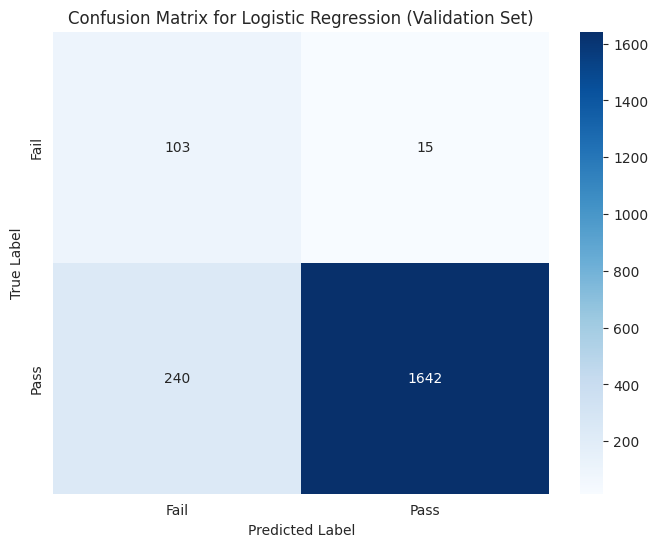

In [98]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#generate the confusion matrix
cm = confusion_matrix(y_cls_val, y_pred_val, labels=['Fail', 'Pass'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title('Confusion Matrix for Logistic Regression (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

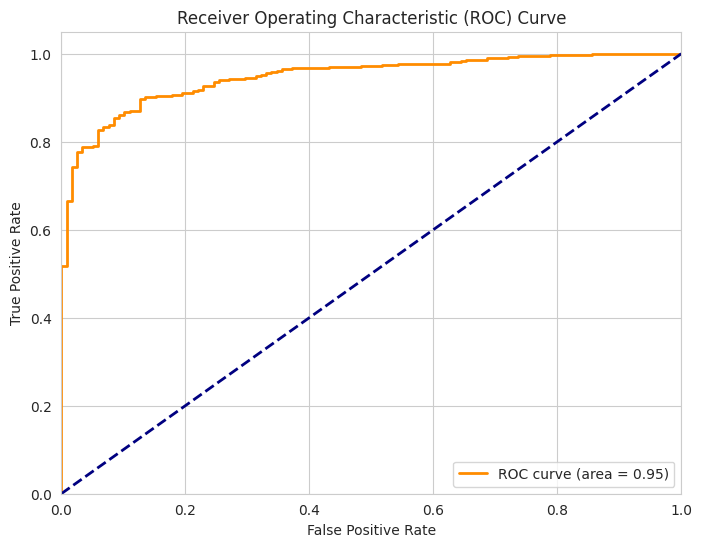

AUC Score: 0.9475


In [99]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_cls_val, y_pred_proba_val, pos_label='Pass')

# Calculate AUC score
auc = roc_auc_score(y_cls_val, y_pred_proba_val)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC Score: {auc:.4f}")

ROC answers the question: How well does the model rank Pass students above Fail students at all thresholds?

AUC measures: How good the model is at separating the two classes


Top 10 most important features:
                       Feature  Coefficient  Absolute_Coefficient
18               midterm_score     2.909052              2.909052
17              quiz_avg_score     1.803171              1.803171
16  assignment_submission_rate     1.586603              1.586603
15     lecture_attendance_rate     1.498835              1.498835
34           num_prerequisites    -0.140295              0.140295
32    teacher_experience_years     0.129801              0.129801
30          exam_anxiety_level    -0.109477              0.109477
4             commute_time_min     0.094123              0.094123
31    course_difficulty_rating     0.093885              0.093885
14     academic_warnings_count    -0.085011              0.085011


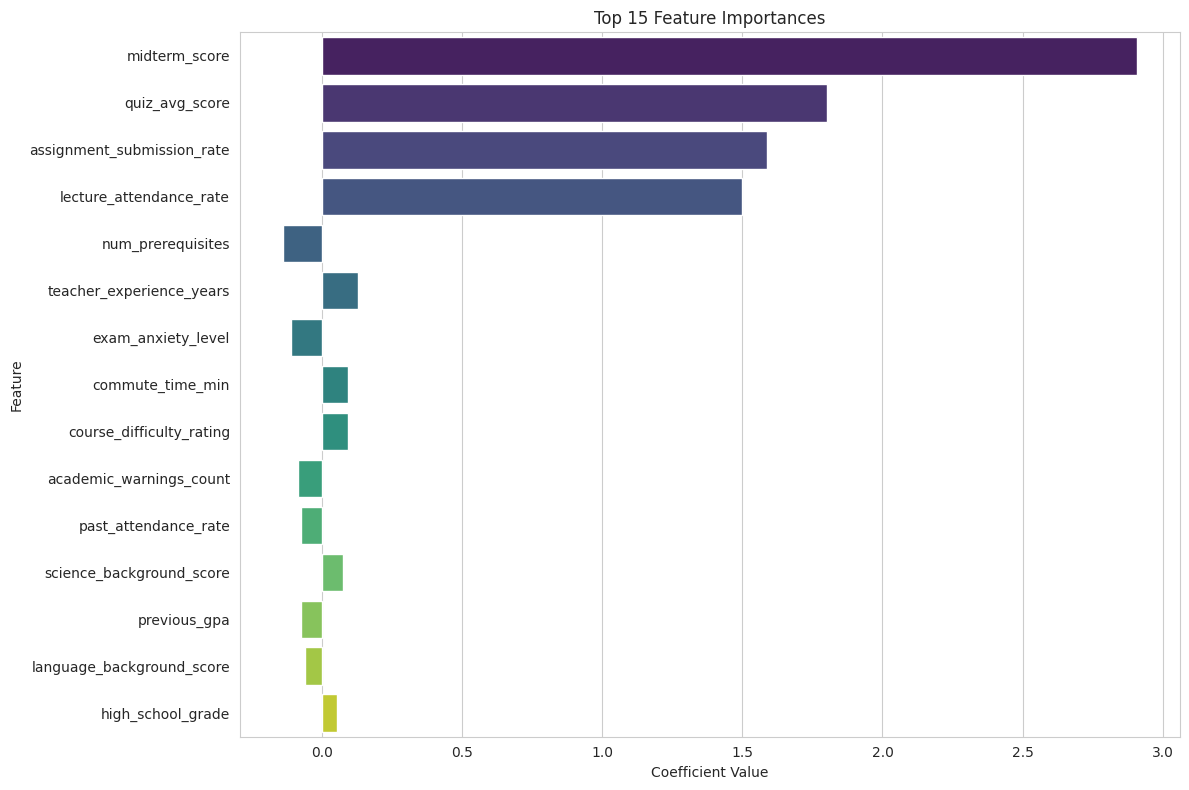

In [100]:
feature_importance = pd.DataFrame({
    'Feature': X_train_res.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

#absolute coefficients for easier sorting by magnitude
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=feature_importance.head(15), palette='viridis', legend=False)
plt.title('Top 15 Feature Importances')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Logistic Regression "Multiclass Logistic Regression applied to final_grade target feature"**

In [101]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

#load the preprocessed feature sets (X_train, X_val, X_test) that were saved earlier
X_train_processed = pd.read_csv('X_train_imputed_preprocessed.csv')
X_val_processed = pd.read_csv('X_val_imputed_preprocessed.csv')
X_test_processed = pd.read_csv('X_test_imputed_preprocessed.csv')

#get the final_grade target from the imputed dataframe
y_cls_grade_full = df_imputed['final_grade']

target_cols = ['final_score', 'final_grade', 'pass_fail']
X_original = df_imputed.drop(columns=target_cols)
y_reg_original = df_imputed['final_score']
y_cls_original = df_imputed['pass_fail']

X_train_val_idx, X_test_idx, _, _ = train_test_split(
    X_original.index, y_reg_original, test_size=0.2, random_state=42
)

val_size_of_train_val_chunk = 0.1 / 0.8
X_train_idx, X_val_idx, _, _ = train_test_split(
    X_train_val_idx, y_reg_original.loc[X_train_val_idx], test_size=val_size_of_train_val_chunk, random_state=42
)

#now use these indices to get the corresponding y_cls_grade splits
y_cls_grade_train = y_cls_grade_full.loc[X_train_idx]
y_cls_grade_val = y_cls_grade_full.loc[X_val_idx]
y_cls_grade_test = y_cls_grade_full.loc[X_test_idx]

# Check class distribution before SMOTE on the training target
#print(f"Original class distribution for final_grade (training set): {Counter(y_cls_grade_train)}")

#apply SMOTE to balance the final_grade training data
#sm_grade = SMOTE(random_state=42)
#X_train_res_grade, y_cls_grade_train_res = sm_grade.fit_resample(X_train_processed, y_cls_grade_train)

#print(f"Resampled class distribution for final_grade (training set): {Counter(y_cls_grade_train_res)}")

X_val_grade_scaled = X_val_processed
X_train_grade = X_train_processed
y_train_grade = y_cls_grade_train

In [102]:
from sklearn.linear_model import LogisticRegression

#model initialization with class_weight='balanced'
model_lr_grade = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
model_lr_grade.fit(X_train_grade, y_train_grade)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [103]:
y_pred_grade = model_lr_grade.predict(X_val_grade_scaled)
y_pred_proba_grade = model_lr_grade.predict_proba(X_val_grade_scaled)

In [104]:
from sklearn.metrics import accuracy_score

accuracy_grade = accuracy_score(y_cls_grade_val, y_pred_grade)
print(f"Multinomial Logistic Regression Accuracy on Validation Set: {accuracy_grade:.4f}")

Multinomial Logistic Regression Accuracy on Validation Set: 0.4030


In [105]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("\nClassification Report for Multinomial Logistic Regression (Validation Set):")
print(classification_report(y_cls_grade_val, y_pred_grade))


Classification Report for Multinomial Logistic Regression (Validation Set):
              precision    recall  f1-score   support

           A       0.18      0.70      0.29        47
           B       0.22      0.56      0.31       174
           C       0.81      0.34      0.48      1411
           D       0.29      0.50      0.37       312
           F       0.18      0.80      0.30        56

    accuracy                           0.40      2000
   macro avg       0.34      0.58      0.35      2000
weighted avg       0.65      0.40      0.44      2000



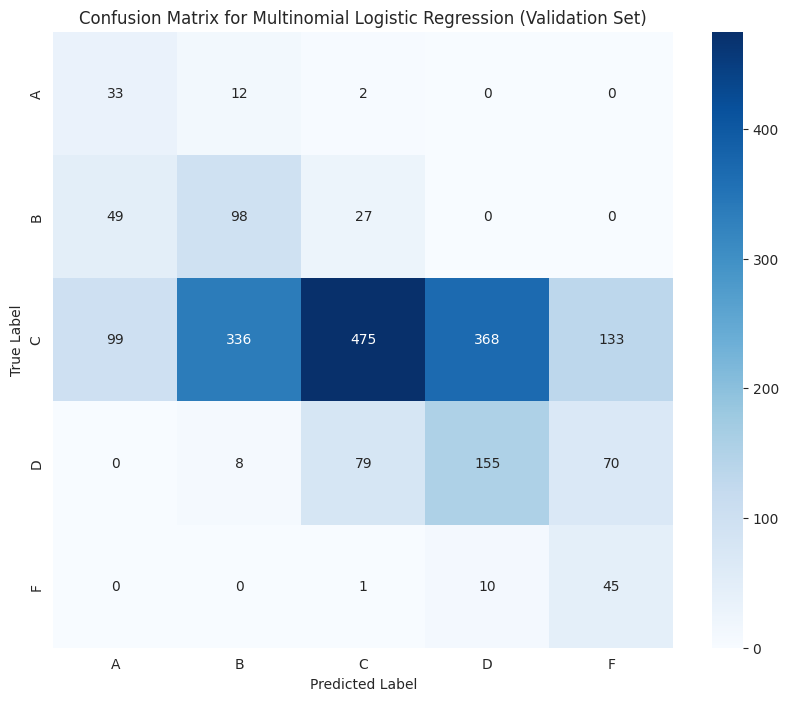

In [106]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm_grade = confusion_matrix(y_cls_grade_val, y_pred_grade, labels=model_lr_grade.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_grade, annot=True, fmt='d', cmap='Blues', xticklabels=model_lr_grade.classes_, yticklabels=model_lr_grade.classes_)
plt.title('Confusion Matrix for Multinomial Logistic Regression (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

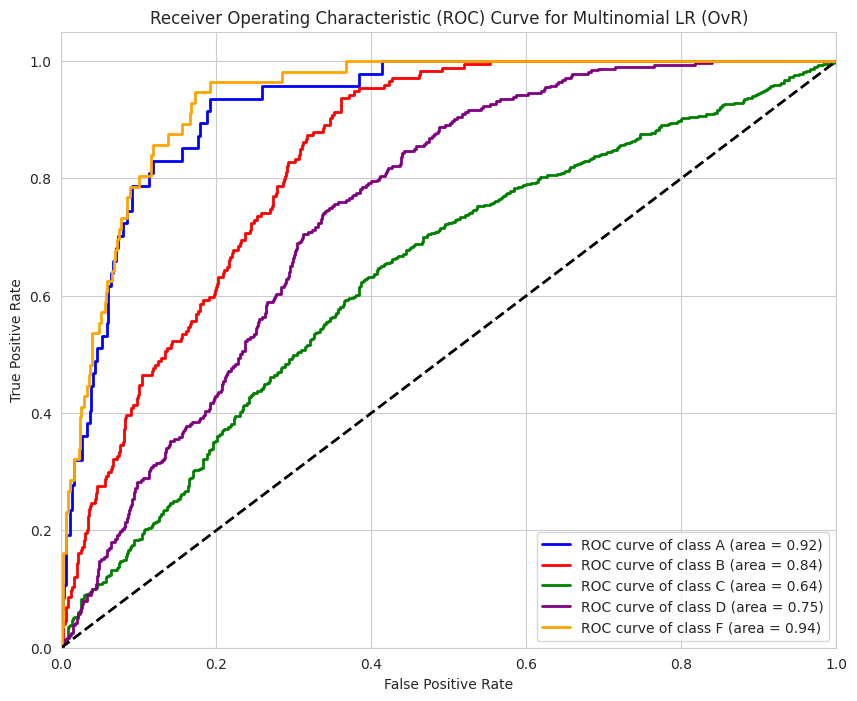

AUC scores for each class:
  Class A: 0.9247
  Class B: 0.8376
  Class C: 0.6375
  Class D: 0.7491
  Class F: 0.9369


In [107]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#get the number of classes and their labels
n_classes = len(model_lr_grade.classes_)
class_labels = model_lr_grade.classes_

#compute ROC curve and ROC area for each class (OvR)
fpr = dict()
tpr = dict()
roc_auc = dict()

#convert y_cls_grade_val to numerical labels for OvR
y_true_numerical = pd.Series([list(class_labels).index(grade) for grade in y_cls_grade_val], index=y_cls_grade_val.index)

for i in range(n_classes):
    class_label = class_labels[i]
    #binarize the true labels for the current class
    y_true_bin = (y_true_numerical == i).astype(int)

    #get the probability for the current class
    y_score = y_pred_proba_grade[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true_bin, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange'] # Example colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multinomial LR (OvR)')
plt.legend(loc="lower right")
plt.show()

print("AUC scores for each class:")
for i in range(n_classes):
    print(f"  Class {class_labels[i]}: {roc_auc[i]:.4f}")

Top 10 most important features (overall, by absolute mean coefficient):
                      Feature  Absolute_Coefficient
0               midterm_score              1.680826
1              quiz_avg_score              1.061275
2  assignment_submission_rate              0.878642
3     lecture_attendance_rate              0.871356
4                stress_level              0.083665
5   study_hours_last_semester              0.054081
6                         age              0.051549
7                num_siblings              0.048980
8    course_difficulty_rating              0.045520
9                  class_size              0.040649


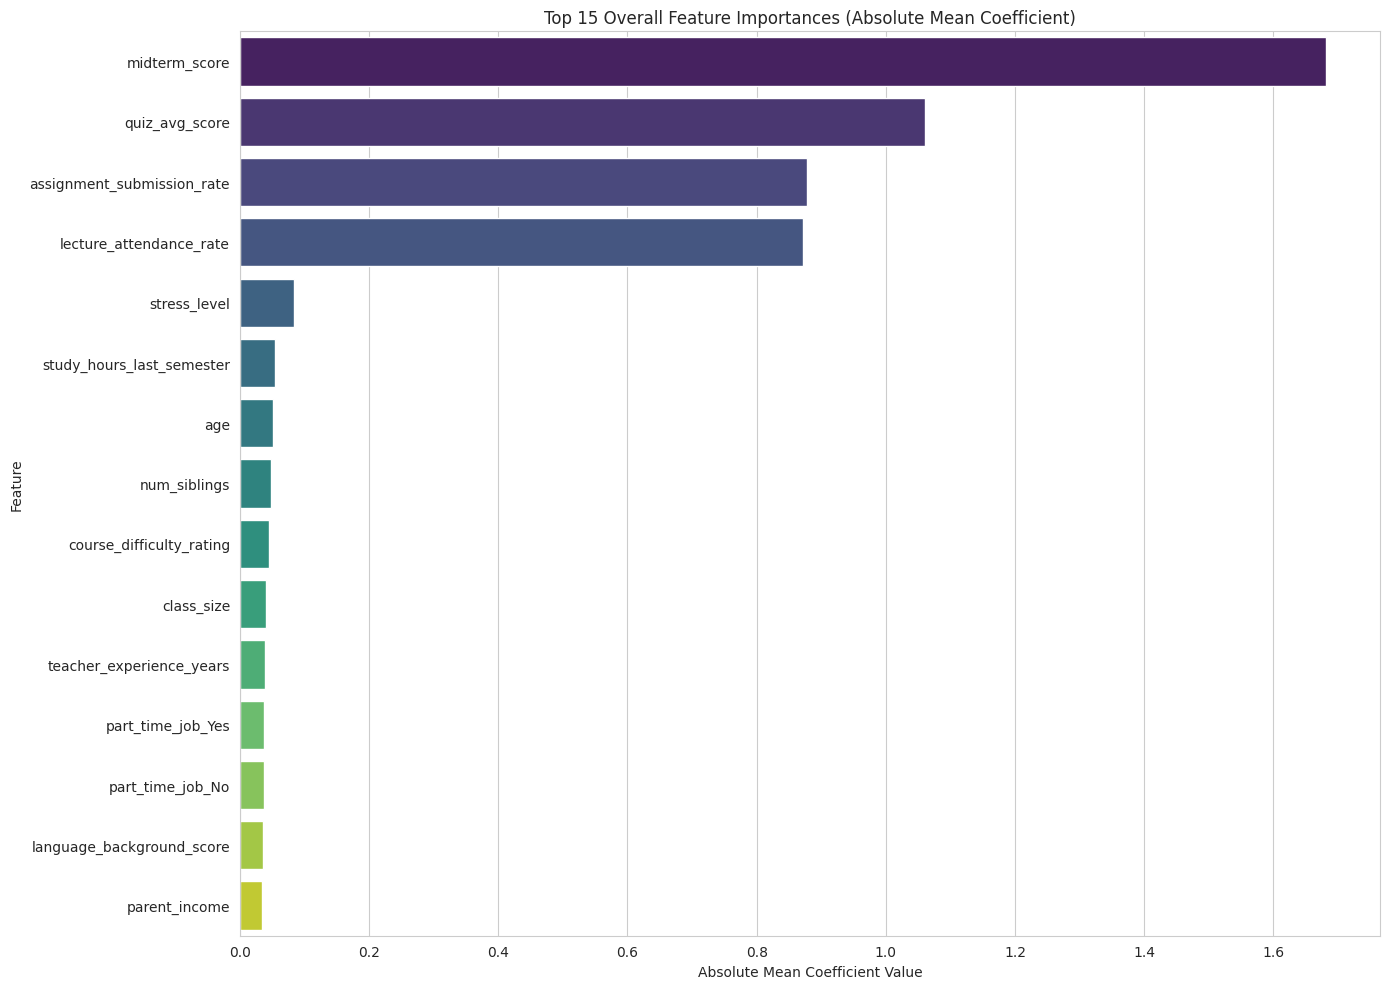

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X_train_grade.columns
coefficients = model_lr_grade.coef_
feature_importance_list = []

for i, class_label in enumerate(class_labels):
    class_coef = coefficients[i]
    df_coef = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': class_coef
    })
    df_coef['Absolute_Coefficient'] = df_coef['Coefficient'].abs()
    df_coef['Class'] = class_label
    feature_importance_list.append(df_coef)

all_feature_importance = pd.concat(feature_importance_list)

overall_feature_importance = all_feature_importance.groupby('Feature')['Absolute_Coefficient'].mean().sort_values(ascending=False).reset_index()

print("Top 10 most important features (overall, by absolute mean coefficient):")
print(overall_feature_importance.head(10))

plt.figure(figsize=(14, 10))
sns.barplot(x='Absolute_Coefficient', y='Feature', hue='Feature', data=overall_feature_importance.head(15), palette='viridis', legend=False)
plt.title('Top 15 Overall Feature Importances (Absolute Mean Coefficient)')
plt.xlabel('Absolute Mean Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**SVM applied to pass_fail target feature**

In [109]:
from sklearn.svm import LinearSVC

#set dual=False as n_samples > n_features for efficiency with large datasets
model_svc = LinearSVC(random_state=42, max_iter=1000, dual=False)

#train the model
model_svc.fit(X_train_res, y_cls_train_res)

LinearSVC(dual=False, random_state=42)

In [110]:
y_pred_val_svc = model_svc.predict(X_val)
y_pred_proba_val_svc = model_svc.decision_function(X_val) #linearSVC provides decision_function instead of predict_proba

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_svc = accuracy_score(y_cls_val, y_pred_val_svc)
precision_svc = precision_score(y_cls_val, y_pred_val_svc, pos_label='Pass')
recall_svc = recall_score(y_cls_val, y_pred_val_svc, pos_label='Pass')
f1_svc = f1_score(y_cls_val, y_pred_val_svc, pos_label='Pass')

print(f"SVM Accuracy: {accuracy_svc:.4f}")
print(f"SVM Precision: {precision_svc:.4f}")
print(f"SVM Recall: {recall_svc:.4f}")
print(f"SVM F1-Score: {f1_svc:.4f}")

SVM Accuracy: 0.8705
SVM Precision: 0.9915
SVM Recall: 0.8698
SVM F1-Score: 0.9267


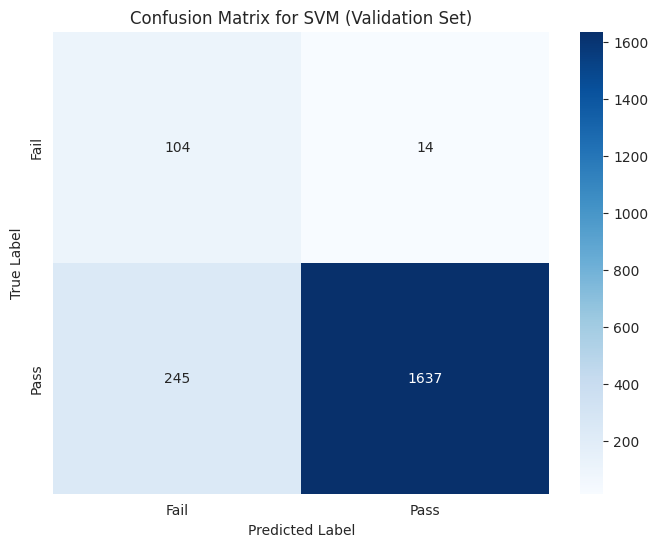

In [112]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm_svc = confusion_matrix(y_cls_val, y_pred_val_svc, labels=['Fail', 'Pass'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title('Confusion Matrix for SVM (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

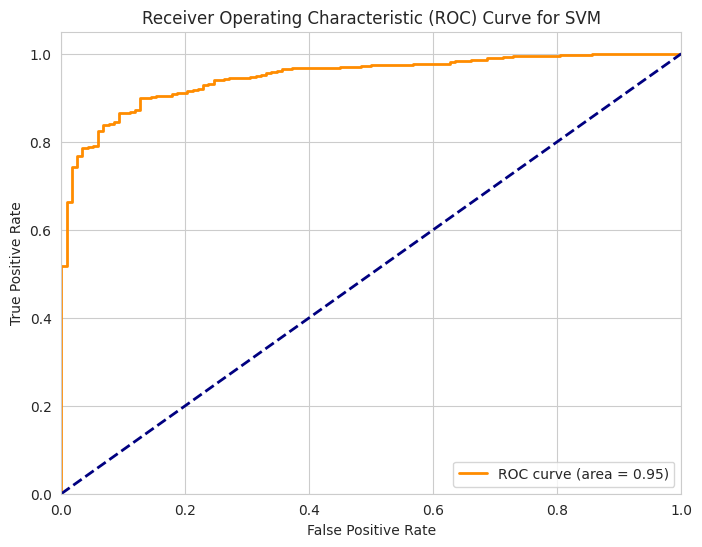

SVM AUC Score: 0.9477


In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve. LinearSVC's decision_function output is used as score.
# Ensure 'pos_label' matches the positive class string in y_cls_val.
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_cls_val, y_pred_proba_val_svc, pos_label='Pass')

# Calculate AUC score
auc_svc = roc_auc_score(y_cls_val, y_pred_proba_val_svc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC curve (area = {auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()

print(f"SVM AUC Score: {auc_svc:.4f}")

Top 10 most important features for SVM:
                       Feature  Coefficient  Absolute_Coefficient
18               midterm_score     0.923929              0.923929
17              quiz_avg_score     0.568567              0.568567
16  assignment_submission_rate     0.499572              0.499572
15     lecture_attendance_rate     0.477173              0.477173
34           num_prerequisites    -0.043676              0.043676
32    teacher_experience_years     0.037905              0.037905
31    course_difficulty_rating     0.033140              0.033140
14     academic_warnings_count    -0.032246              0.032246
30          exam_anxiety_level    -0.031584              0.031584
4             commute_time_min     0.030804              0.030804


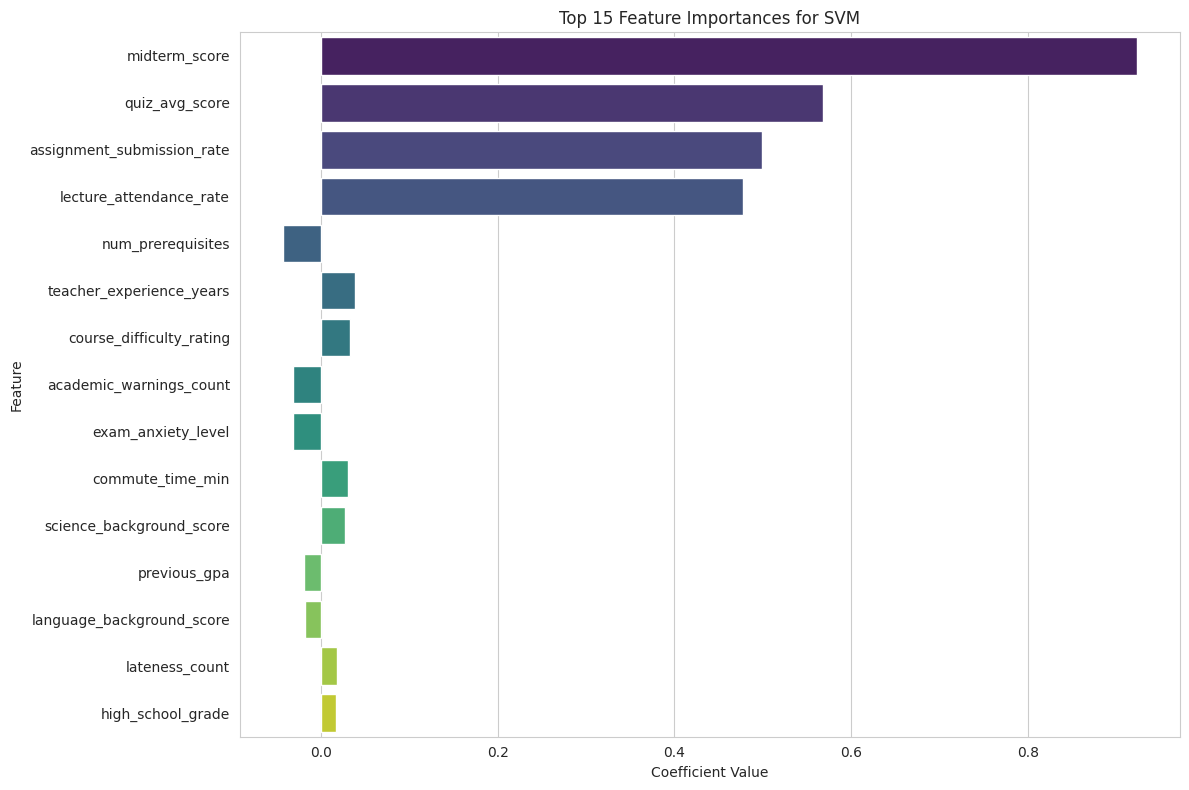

In [114]:
feature_importance_svc = pd.DataFrame({
    'Feature': X_train_res.columns,
    'Coefficient': model_svc.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Calculate absolute coefficients for sorting by magnitude
feature_importance_svc['Absolute_Coefficient'] = feature_importance_svc['Coefficient'].abs()
feature_importance_svc = feature_importance_svc.sort_values(by='Absolute_Coefficient', ascending=False)

print("Top 10 most important features for SVM:")
print(feature_importance_svc.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=feature_importance_svc.head(15), palette='viridis', legend=False)
plt.title('Top 15 Feature Importances for SVM')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**SVM applied to final_grade target feature**

In [115]:
grade_mapping = {'F': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}

y_train_grade_numerical = y_train_grade.map(grade_mapping).astype(int)
y_val_grade_numerical = y_cls_grade_val.map(grade_mapping).astype(int)

print("Categorical grades mapped to numerical representation.")
print(f"y_train_grade_numerical head:\n{y_train_grade_numerical.head()}")
print(f"y_val_grade_numerical head:\n{y_val_grade_numerical.head()}")

Categorical grades mapped to numerical representation.
y_train_grade_numerical head:
9570     2
19298    1
9589     2
6709     2
10910    2
Name: final_grade, dtype: int64
y_val_grade_numerical head:
17353    2
16081    3
8282     2
1113     2
9546     2
Name: final_grade, dtype: int64


In [116]:
unique_grades_sorted = sorted(y_train_grade_numerical.unique())
#If 'F' is present, its numerical value is 0. So we filter for values > 0.
unique_grades_sorted = [g for g in unique_grades_sorted if g > 0]

y_train_binary_targets = {}
y_val_binary_targets = {}

reverse_grade_mapping = {v: k for k, v in grade_mapping.items()}

for num_grade in unique_grades_sorted:
    grade_letter = reverse_grade_mapping[num_grade]
    threshold_name = f'ge_{grade_letter}'

    #create binary target for training set
    y_train_binary_targets[threshold_name] = (y_train_grade_numerical >= num_grade).astype(int)

    #create binary target for validation set
    y_val_binary_targets[threshold_name] = (y_val_grade_numerical >= num_grade).astype(int)

print("Binary target variables created for each grade threshold.")
for key, value in y_train_binary_targets.items():
    print(f"\n{key} (Training Set) class distribution:\n{value.value_counts()}")
for key, value in y_val_binary_targets.items():
    print(f"\n{key} (Validation Set) class distribution:\n{value.value_counts()}")

Binary target variables created for each grade threshold.

ge_D (Training Set) class distribution:
final_grade
1    13590
0      410
Name: count, dtype: int64

ge_C (Training Set) class distribution:
final_grade
1    11285
0     2715
Name: count, dtype: int64

ge_B (Training Set) class distribution:
final_grade
0    12621
1     1379
Name: count, dtype: int64

ge_A (Training Set) class distribution:
final_grade
0    13703
1      297
Name: count, dtype: int64

ge_D (Validation Set) class distribution:
final_grade
1    1944
0      56
Name: count, dtype: int64

ge_C (Validation Set) class distribution:
final_grade
1    1632
0     368
Name: count, dtype: int64

ge_B (Validation Set) class distribution:
final_grade
0    1779
1     221
Name: count, dtype: int64

ge_A (Validation Set) class distribution:
final_grade
0    1953
1      47
Name: count, dtype: int64


In [117]:
ordinal_models = {}

for threshold_name, y_binary_train in y_train_binary_targets.items():


    #apply SMOTE to balance classes
    sm_grade = SMOTE(random_state=42)
    X_resampled, y_resampled = sm_grade.fit_resample(X_train_grade, y_binary_train)

    #instantiate and train LinearSVC model
    model_grade_svc = LinearSVC(random_state=42, max_iter=1000, dual=False)
    model_grade_svc.fit(X_resampled, y_resampled)

    #store the trained model
    ordinal_models[threshold_name] = model_grade_svc

In [118]:
y_pred_ordinal_val = []
y_pred_binary_val = {}

#ensure the threshold names are sorted in descending order of grade (A, B, C, D)
sorted_threshold_names = sorted(ordinal_models.keys(), reverse=True)

for threshold_name in sorted_threshold_names:
    model_grade_svc = ordinal_models[threshold_name]
    #get binary predictions for the current threshold
    y_pred_binary_val[threshold_name] = model_grade_svc.predict(X_val_grade_scaled)

In [119]:
y_pred_ordinal_val = []

#iterate through each instance in the validation set
for i in range(len(X_val_grade_scaled)):
    predicted_grade = 0

    #loop through the thresholds from highest grade ('ge_A') down to 'ge_D'
    #the order needs to be from A down to D so that the highest met threshold is captured.
    for threshold_name in sorted(y_pred_binary_val.keys(), reverse=False):
        if y_pred_binary_val[threshold_name][i] == 1: #if the prediction is 1 (meets or exceeds this grade)
            #get the numerical value for the grade associated with this threshold
            grade_letter = threshold_name.split('_')[1]
            numerical_grade_for_threshold = grade_mapping[grade_letter]
            predicted_grade = numerical_grade_for_threshold
            #if we predict 1 for 'ge_A', then the grade is 'A', and we can stop
            #if we predict 1 for 'ge_B' but 0 for 'ge_A', then the grade is 'B'
            break

    y_pred_ordinal_val.append(predicted_grade)

#convert numerical predictions back to categorical grades
reverse_grade_mapping = {v: k for k, v in grade_mapping.items()}
y_pred_final_grade = pd.Series(y_pred_ordinal_val).map(reverse_grade_mapping)
print(f"Predicted final grades head:\n{y_pred_final_grade.head()}")

Predicted final grades head:
0    F
1    B
2    D
3    C
4    C
dtype: object


Overall Ordinal Grade Prediction Accuracy: 0.4035

Confusion Matrix for Ordinal Grade Prediction:
[[ 49   6   1   0   0]
 [ 92 130  85   5   0]
 [182 305 523 219 182]
 [  0   0  30  66  78]
 [  0   0   2   6  39]]


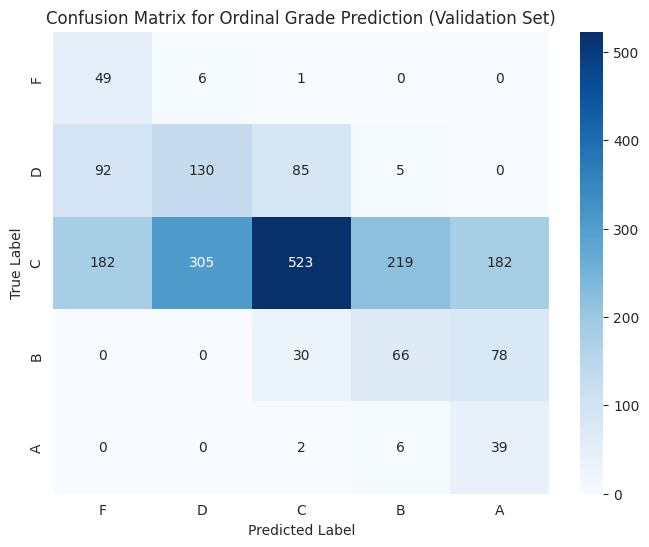


Classification Report for Ordinal Grade Prediction:
              precision    recall  f1-score   support

           F       0.15      0.88      0.26        56
           D       0.29      0.42      0.35       312
           C       0.82      0.37      0.51      1411
           B       0.22      0.38      0.28       174
           A       0.13      0.83      0.23        47

    accuracy                           0.40      2000
   macro avg       0.32      0.57      0.32      2000
weighted avg       0.65      0.40      0.45      2000



In [120]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_grade = accuracy_score(y_cls_grade_val, y_pred_final_grade)
print(f"Overall Ordinal Grade Prediction Accuracy: {accuracy_grade:.4f}")

class_labels = ['F', 'D', 'C', 'B', 'A']
cm_grade = confusion_matrix(y_cls_grade_val, y_pred_final_grade, labels=class_labels)
print("\nConfusion Matrix for Ordinal Grade Prediction:")
print(cm_grade)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_grade, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Ordinal Grade Prediction (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report for Ordinal Grade Prediction:")
print(classification_report(y_cls_grade_val, y_pred_final_grade, labels=class_labels))

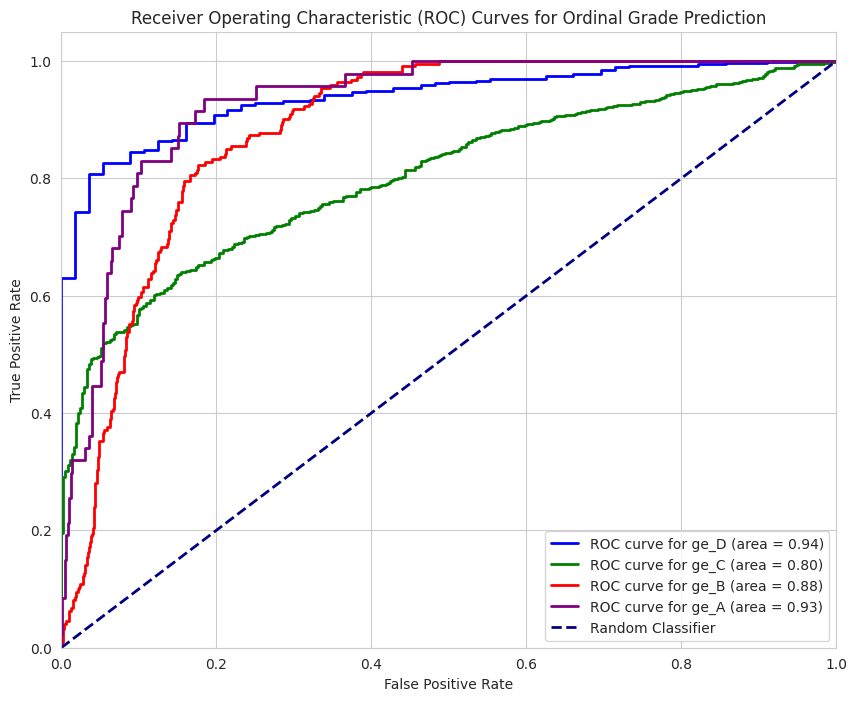

AUC Scores for each binary classifier:
ge_D: 0.9391
ge_C: 0.8021
ge_B: 0.8847
ge_A: 0.9270


In [121]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']

#iterate through each trained model and its corresponding validation target
for i, (threshold_name, model_grade_svc) in enumerate(ordinal_models.items()):
    y_true_bin = y_val_binary_targets[threshold_name]

    #get decision function scores from LinearSVC (instead of predict_proba)
    y_score = model_grade_svc.decision_function(X_val_grade_scaled)
    fpr[threshold_name], tpr[threshold_name], _ = roc_curve(y_true_bin, y_score, pos_label=1)
    roc_auc[threshold_name] = roc_auc_score(y_true_bin, y_score)
    plt.plot(fpr[threshold_name], tpr[threshold_name], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve for {threshold_name} (area = {roc_auc[threshold_name]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Ordinal Grade Prediction')
plt.legend(loc='lower right')
plt.show()

print("AUC Scores for each binary classifier:")
for threshold, auc_score in roc_auc.items():
    print(f"{threshold}: {auc_score:.4f}")

In [122]:
feature_importance_list = []

for threshold_name, model_grade_svc in ordinal_models.items():
    #extract grade letter from threshold_name (e.g., 'ge_A' -> 'A')
    grade_letter = threshold_name.split('_')[1]

    #create DataFrame for coefficients
    df_coef = pd.DataFrame({
        'Feature': X_train_grade.columns,
        'Coefficient': model_grade_svc.coef_[0]
    })
    df_coef['Absolute_Coefficient'] = df_coef['Coefficient'].abs()
    df_coef['Class'] = grade_letter
    feature_importance_list.append(df_coef)

In [123]:
all_feature_importance = pd.concat(feature_importance_list, ignore_index=True)

#calculate the mean of the absolute coefficients for each feature across all classes
mean_abs_coefficients = all_feature_importance.groupby('Feature')['Absolute_Coefficient'].mean().sort_values(ascending=False)

#select the top 10 features based on mean absolute coefficient
top_10_features = mean_abs_coefficients.head(10).index

#create a combined DataFrame (plot_df) containing the feature importances for these top 10 features
plot_df = all_feature_importance[all_feature_importance['Feature'].isin(top_10_features)]

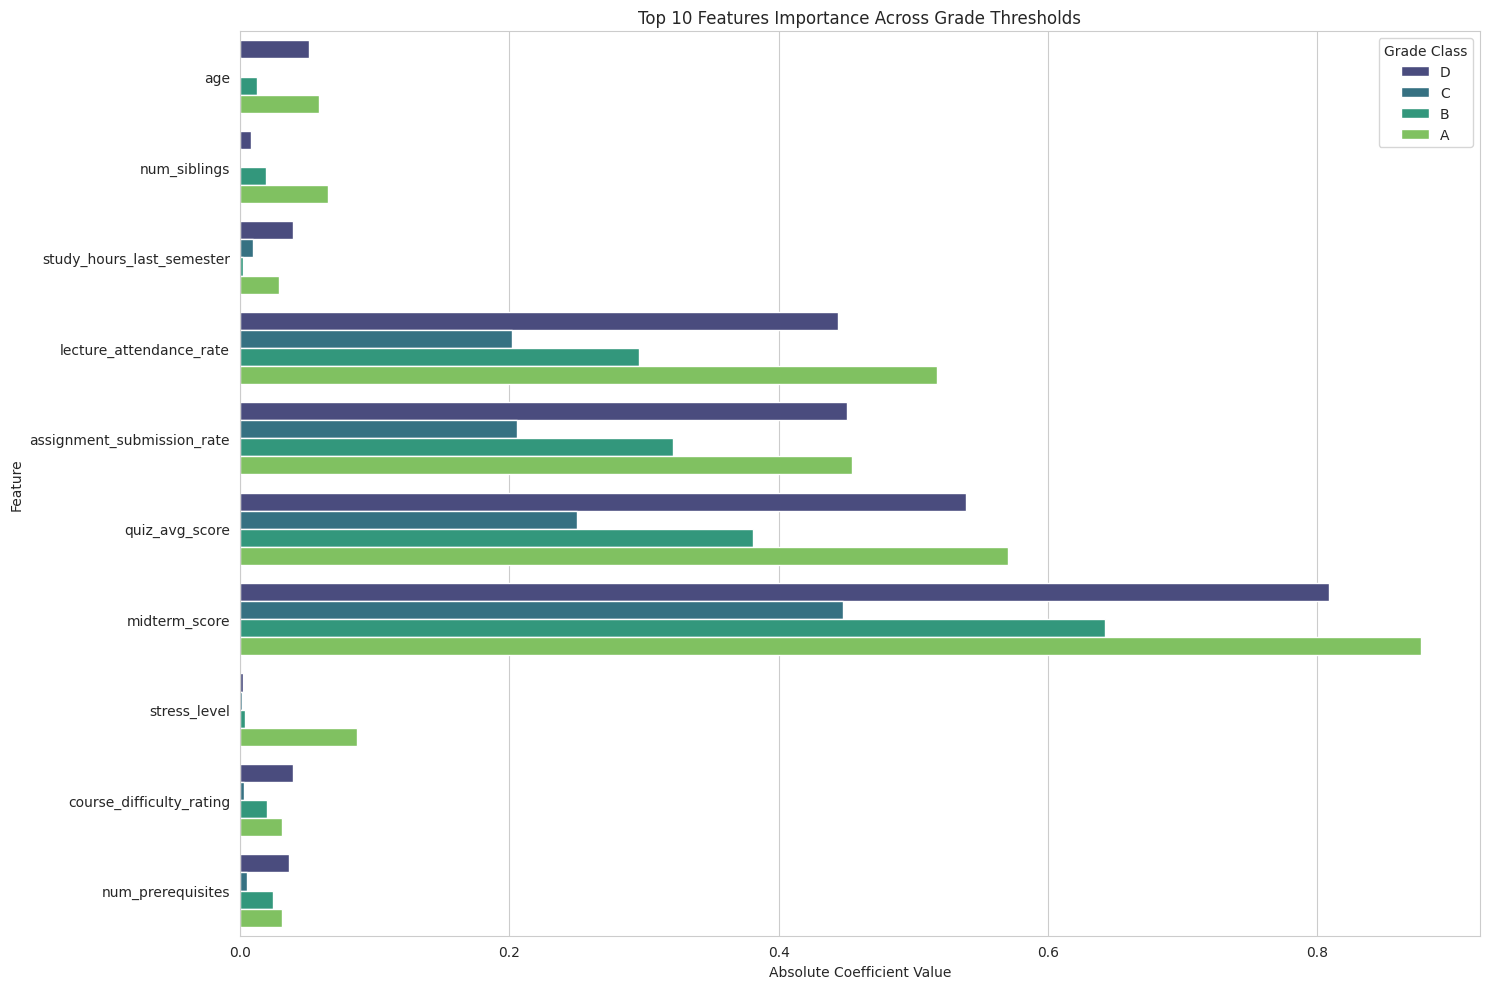

In [124]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Absolute_Coefficient', y='Feature', hue='Class', data=plot_df, palette='viridis', dodge=True)
plt.title('Top 10 Features Importance Across Grade Thresholds')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.legend(title='Grade Class')
plt.tight_layout()
plt.show()

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, auc)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

**Evaluation Helper Function**

In [126]:
def evaluate_model_metrics(model, X_test, y_test, model_name, classes, is_binary=True):
    print(f"\n{'='*10} Evaluating {model_name} {'='*10}")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in classes]))

    # Plotting
    plt.figure(figsize=(12, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True'); plt.xlabel('Predicted')

    # ROC Curve
    plt.subplot(1, 2, 2)
    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score(y_test, y_pred_proba[:, 1]):.2f}')
        plt.plot([0, 1], [0, 1], 'navy', linestyle='--')
    else:
        # One-vs-Rest ROC
        from sklearn.preprocessing import label_binarize
        y_test_bin = label_binarize(y_test, classes=range(len(classes)))
        for i, class_label in enumerate(classes):
            if i < y_pred_proba.shape[1]:
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC={auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')

    plt.legend(loc="lower right")
    plt.title(f'ROC Curve: {model_name}')
    plt.tight_layout()
    plt.show()


**Feature Importance Helper Function**

In [127]:
def plot_feature_importance(model, feature_names, model_name):
    # Get importances based on model type
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"Model {model_name} does not expose feature importances.")
        return

    # Create DataFrame
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15) # Top 15

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_imp_df, palette='viridis', legend=False)
    plt.title(f'Top 15 Feature Importances - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

**Binary Data Setup (Pass/Fail)**


In [128]:
# A. Binary Data Setup (Pass/Fail)
le_binary = LabelEncoder()
y_train_bin_enc = le_binary.fit_transform(y_cls_train_res)
y_val_bin_enc = le_binary.transform(y_cls_val)
binary_classes = le_binary.classes_

**Training for Pass/Fail (Binary)**

In [129]:
# 1. Random Forest (Binary)
rf_binary = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_binary.fit(X_train_res, y_train_bin_enc)

# 2. XGBoost (Binary)
xgb_binary = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_binary.fit(X_train_res, y_train_bin_enc)

# 3. Decision Tree (Binary)
dt_binary = DecisionTreeClassifier(max_depth=8, random_state=42)
dt_binary.fit(X_train_res, y_train_bin_enc)

print("Binary models trained successfully.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:44:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Binary models trained successfully.


**# Evaluate Random Forest for pass/fail**




========== Evaluating Random Forest (Pass/Fail) ==========
Accuracy: 0.9165
Classification Report:
              precision    recall  f1-score   support

        Fail       0.38      0.64      0.48       118
        Pass       0.98      0.93      0.95      1882

    accuracy                           0.92      2000
   macro avg       0.68      0.79      0.72      2000
weighted avg       0.94      0.92      0.93      2000



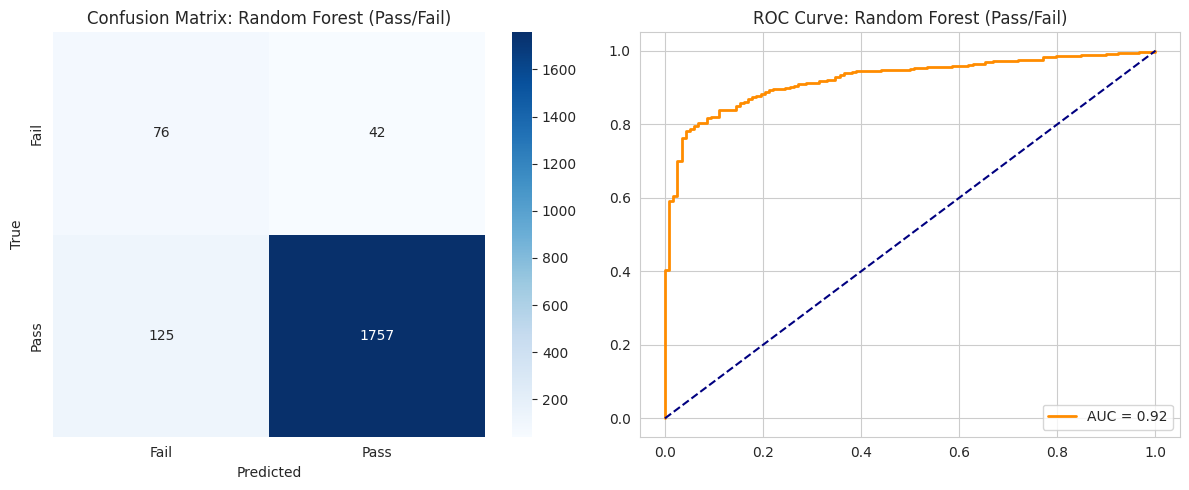

In [130]:
evaluate_model_metrics(rf_binary, X_val, y_val_bin_enc, "Random Forest (Pass/Fail)", binary_classes, is_binary=True)

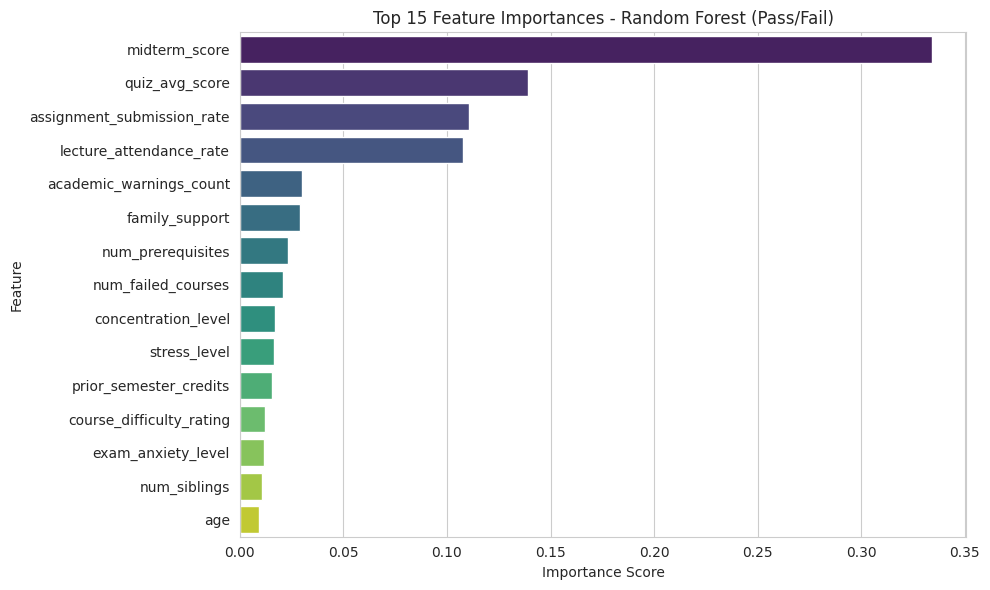

In [131]:
binary_features = X_train_res.columns
multiclass_features = X_train_processed.columns
plot_feature_importance(rf_binary, binary_features, "Random Forest (Pass/Fail)")

**# Evaluate XGBoost for pass/fail**



========== Evaluating XGBoost (Pass/Fail) ==========
Accuracy: 0.9410
Classification Report:
              precision    recall  f1-score   support

        Fail       0.50      0.42      0.45       118
        Pass       0.96      0.97      0.97      1882

    accuracy                           0.94      2000
   macro avg       0.73      0.69      0.71      2000
weighted avg       0.94      0.94      0.94      2000



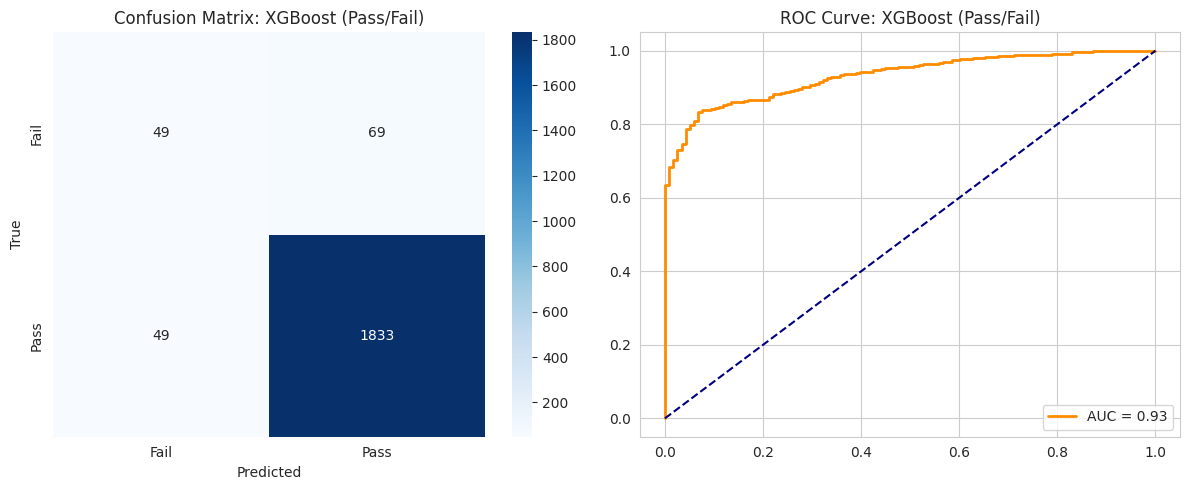

In [132]:
evaluate_model_metrics(xgb_binary, X_val, y_val_bin_enc, "XGBoost (Pass/Fail)", binary_classes, is_binary=True)

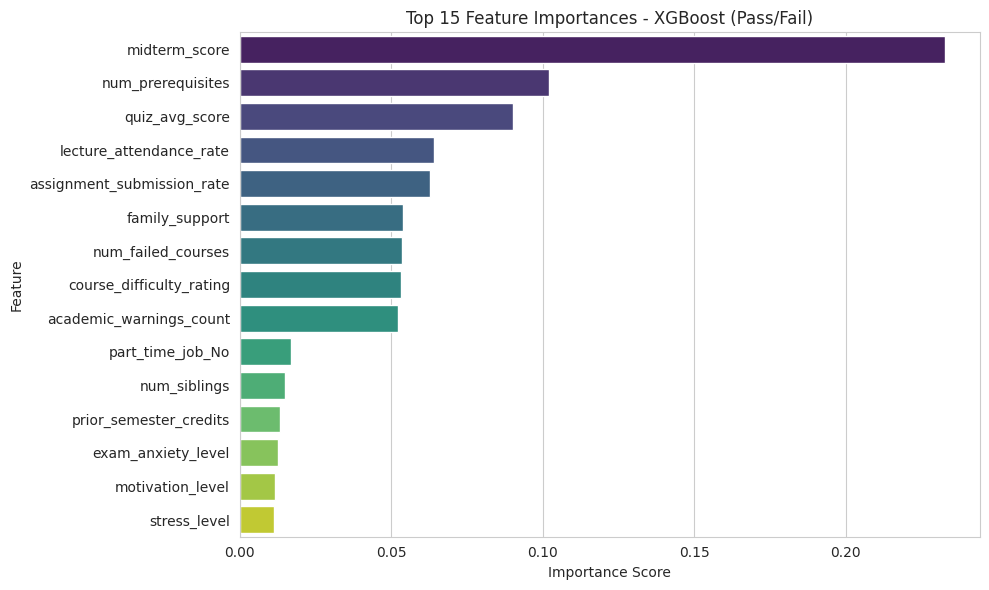

In [133]:
plot_feature_importance(xgb_binary, binary_features, "XGBoost (Pass/Fail)")

**# Evaluate Decision Tree for pass/fail**





========== Evaluating Decision Tree (Pass/Fail) ==========
Accuracy: 0.8530
Classification Report:
              precision    recall  f1-score   support

        Fail       0.26      0.80      0.39       118
        Pass       0.99      0.86      0.92      1882

    accuracy                           0.85      2000
   macro avg       0.62      0.83      0.65      2000
weighted avg       0.94      0.85      0.89      2000



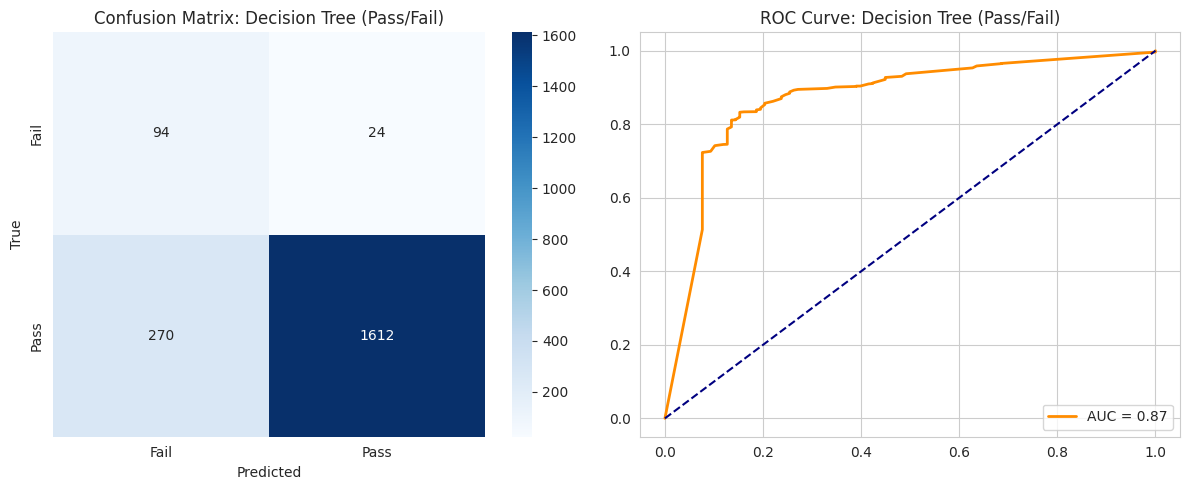

In [134]:
evaluate_model_metrics(dt_binary, X_val, y_val_bin_enc, "Decision Tree (Pass/Fail)", binary_classes, is_binary=True)

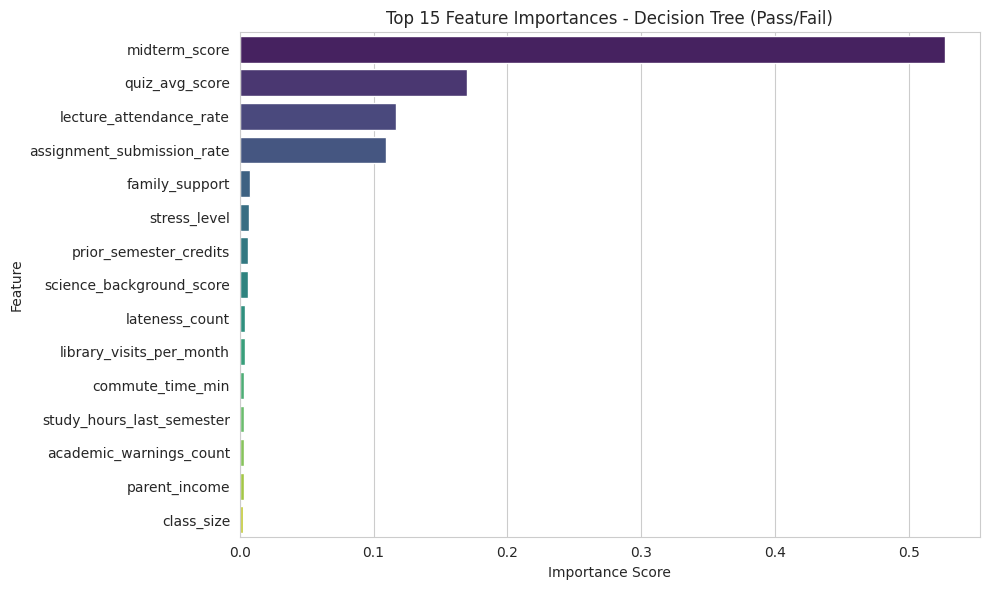

In [135]:
plot_feature_importance(dt_binary, binary_features, "Decision Tree (Pass/Fail)")

**Multiclass Data Setup (Final Grade)**



In [136]:
le_grade = LabelEncoder()
y_train_grade_enc = le_grade.fit_transform(y_cls_grade_train)
y_val_grade_enc = le_grade.transform(y_cls_grade_val)
grade_classes = le_grade.classes_

**Training for Final Grade (Multiclass)**



In [137]:
# 1. Random Forest (Final Grade)
rf_grade = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_grade.fit(X_train_processed, y_train_grade_enc)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)


========== Evaluating Random Forest (Final Grade) ==========
Accuracy: 0.5310
Classification Report:
              precision    recall  f1-score   support

           A       0.23      0.26      0.24        47
           B       0.24      0.37      0.29       174
           C       0.76      0.57      0.65      1411
           D       0.30      0.51      0.38       312
           F       0.30      0.52      0.38        56

    accuracy                           0.53      2000
   macro avg       0.36      0.44      0.39      2000
weighted avg       0.62      0.53      0.56      2000



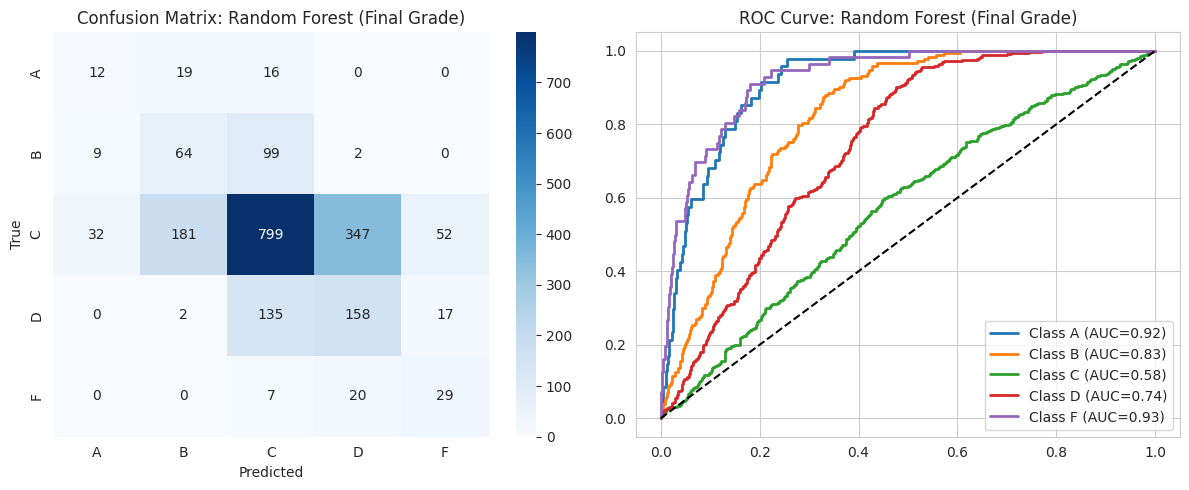

In [138]:
# Evaluate Random Forest
evaluate_model_metrics(rf_grade, X_val_processed, y_val_grade_enc, "Random Forest (Final Grade)", grade_classes, is_binary=False)

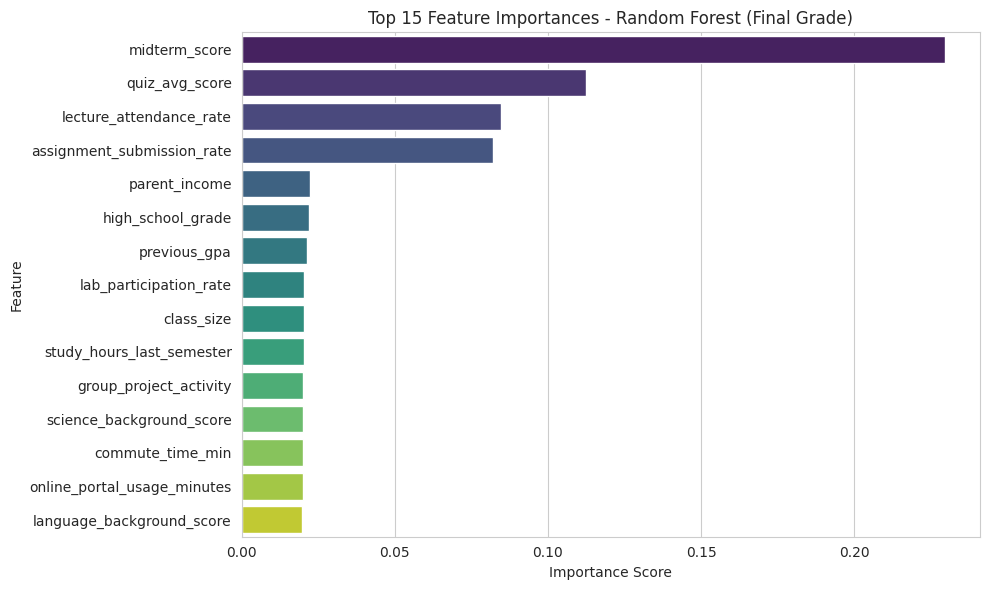

In [139]:
plot_feature_importance(rf_grade, multiclass_features, "Random Forest (Final Grade)")

In [140]:
# 2. XGBoost (Final Grade)
xgb_grade = xgb.XGBClassifier(objective='multi:softprob', num_class=len(grade_classes),
                              use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_grade.fit(X_train_processed, y_train_grade_enc)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:44:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5, ...)


========== Evaluating XGBoost (Final Grade) ==========
Accuracy: 0.6910
Classification Report:
              precision    recall  f1-score   support

           A       0.27      0.06      0.10        47
           B       0.38      0.06      0.10       174
           C       0.71      0.95      0.82      1411
           D       0.32      0.07      0.11       312
           F       0.27      0.05      0.09        56

    accuracy                           0.69      2000
   macro avg       0.39      0.24      0.24      2000
weighted avg       0.60      0.69      0.61      2000



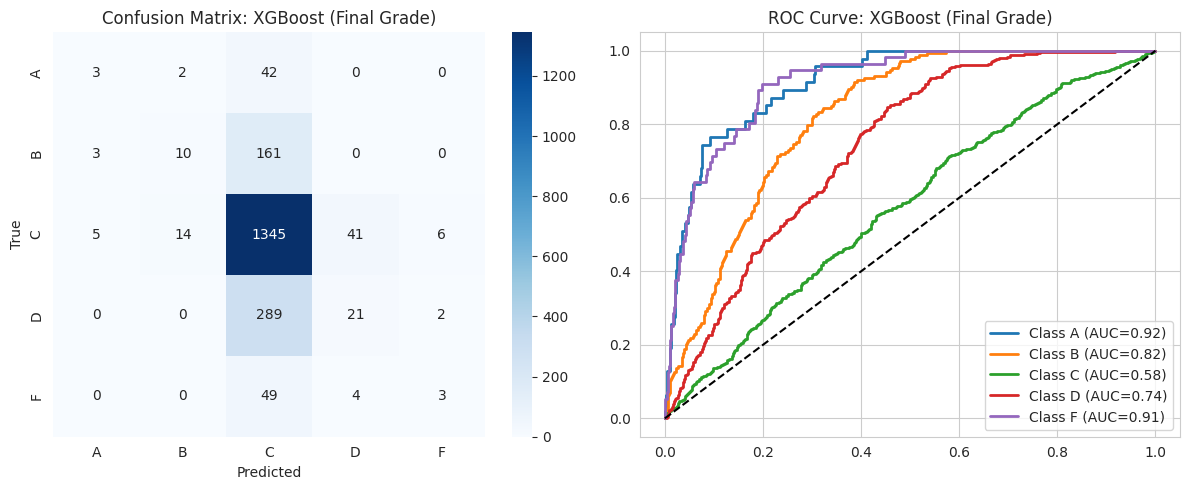

In [141]:
# Evaluate XGBoost
evaluate_model_metrics(xgb_grade, X_val_processed, y_val_grade_enc, "XGBoost (Final Grade)", grade_classes, is_binary=False)

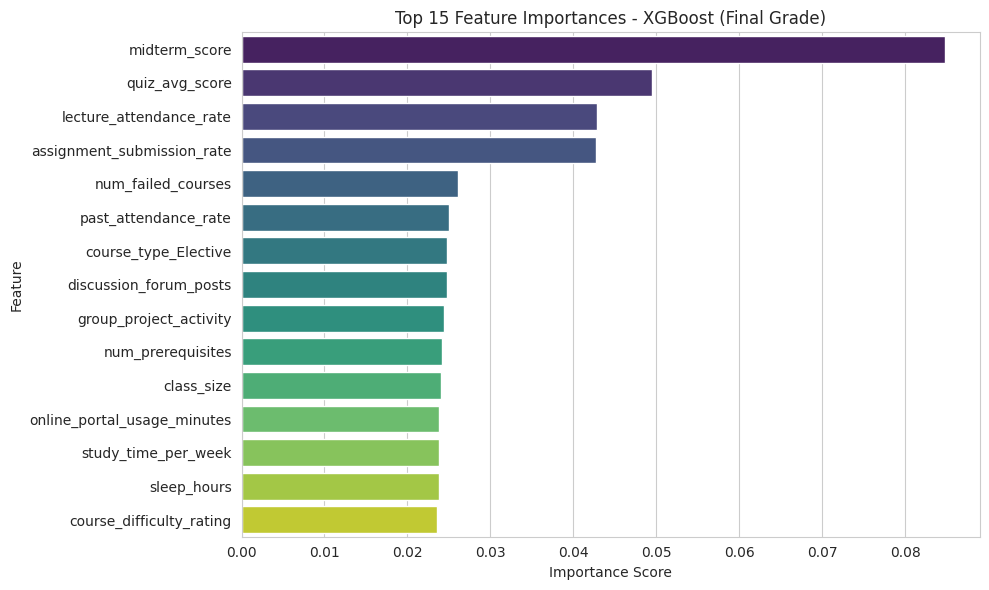

In [142]:
plot_feature_importance(xgb_grade, multiclass_features, "XGBoost (Final Grade)")

In [143]:
# 3. Decision Tree (Final Grade)
dt_grade = DecisionTreeClassifier(max_depth=8, class_weight='balanced', random_state=42)
dt_grade.fit(X_train_processed, y_train_grade_enc)


DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)


========== Evaluating Decision Tree (Final Grade) ==========
Accuracy: 0.3045
Classification Report:
              precision    recall  f1-score   support

           A       0.17      0.66      0.26        47
           B       0.19      0.60      0.29       174
           C       0.76      0.17      0.28      1411
           D       0.27      0.61      0.37       312
           F       0.17      0.73      0.27        56

    accuracy                           0.30      2000
   macro avg       0.31      0.55      0.30      2000
weighted avg       0.61      0.30      0.30      2000



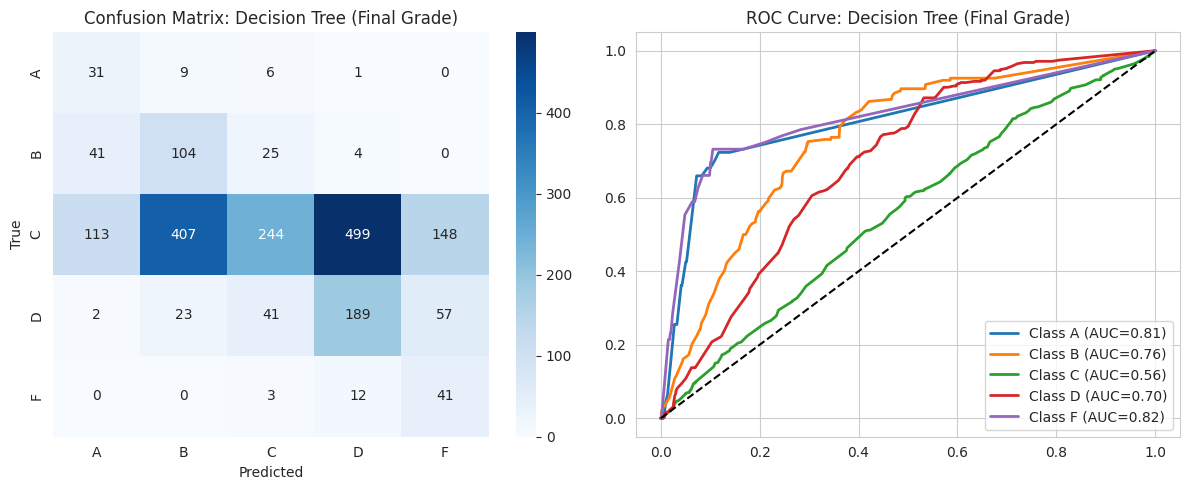

In [144]:
# Evaluate Decision Tree
evaluate_model_metrics(dt_grade, X_val_processed, y_val_grade_enc, "Decision Tree (Final Grade)", grade_classes, is_binary=False)

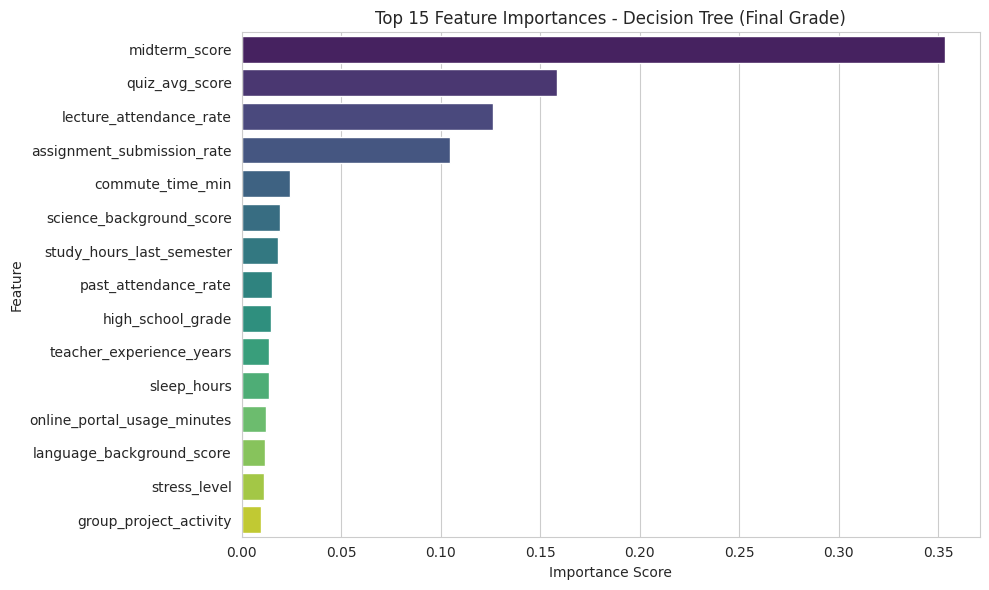

In [145]:
plot_feature_importance(dt_grade, multiclass_features, "Decision Tree (Final Grade)")

**Regression target**

**XGBoost for final_score**

Regression Metrics for final_score:
MSE: 30.9536
MAE: 4.3668
R^2 Score: 0.7385


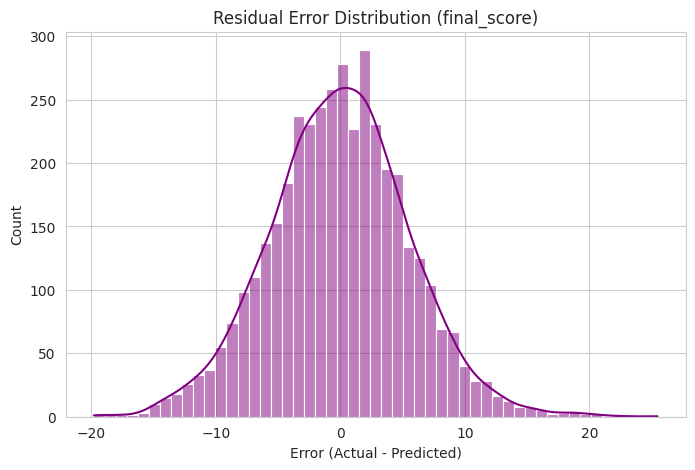

In [146]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize and train
reg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
reg_model.fit(X_train, y_reg_train)

# Predictions
y_reg_pred = reg_model.predict(X_test)

# Evaluation
print(f"Regression Metrics for final_score:")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_reg_pred):.4f}")
print(f"R^2 Score: {r2_score(y_reg_test, y_reg_pred):.4f}")

# Residual Error Plot
plt.figure(figsize=(8, 5))
residuals = y_reg_test - y_reg_pred
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residual Error Distribution (final_score)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

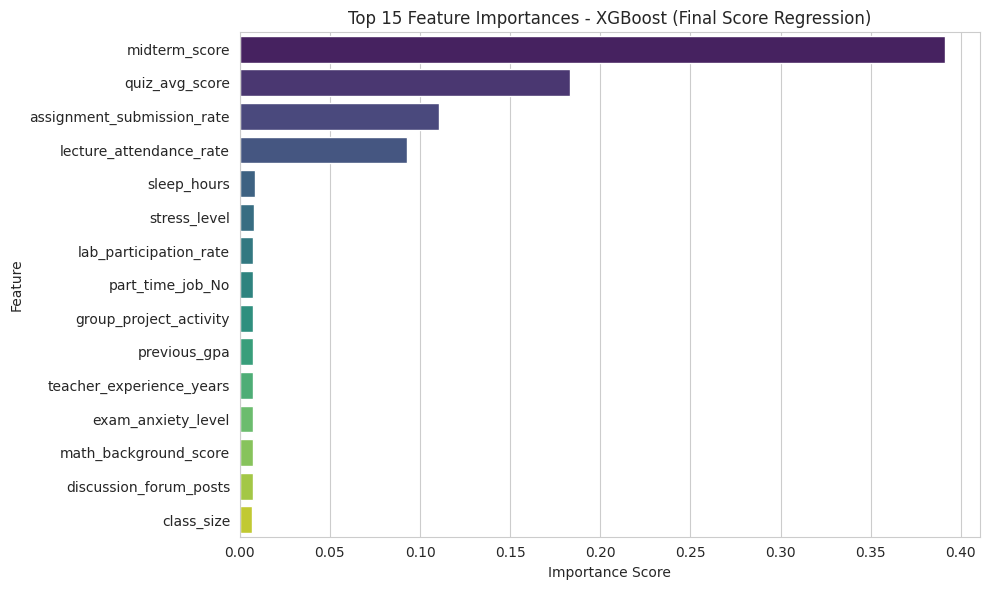

In [147]:
plot_feature_importance(reg_model, X_train.columns, "XGBoost (Final Score Regression)")

**AdaBoost for final_score**

Regression Metrics for final_score (AdaBoost):
MSE: 40.7140
MAE: 5.0862
R^2 Score: 0.6561


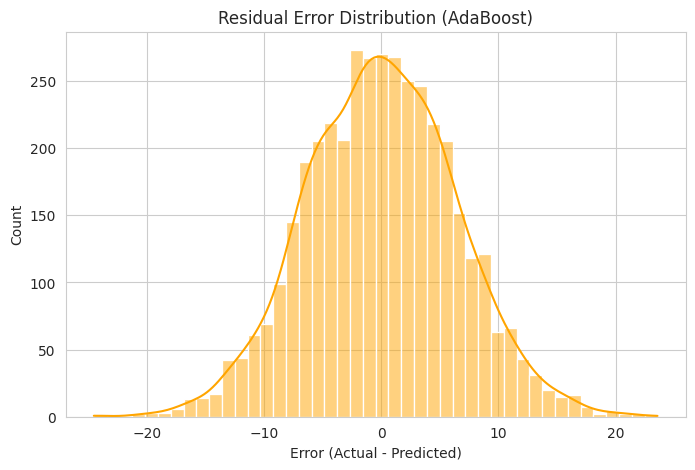

In [148]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train
ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ada_model.fit(X_train, y_reg_train)

# Predictions
y_ada_pred = ada_model.predict(X_test)

# Evaluation
print(f"Regression Metrics for final_score (AdaBoost):")
print(f"MSE: {mean_squared_error(y_reg_test, y_ada_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_ada_pred):.4f}")
print(f"R^2 Score: {r2_score(y_reg_test, y_ada_pred):.4f}")

# Residual Error Plot
plt.figure(figsize=(8, 5))
residuals_ada = y_reg_test - y_ada_pred
sns.histplot(residuals_ada, kde=True, color='orange')
plt.title('Residual Error Distribution (AdaBoost)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

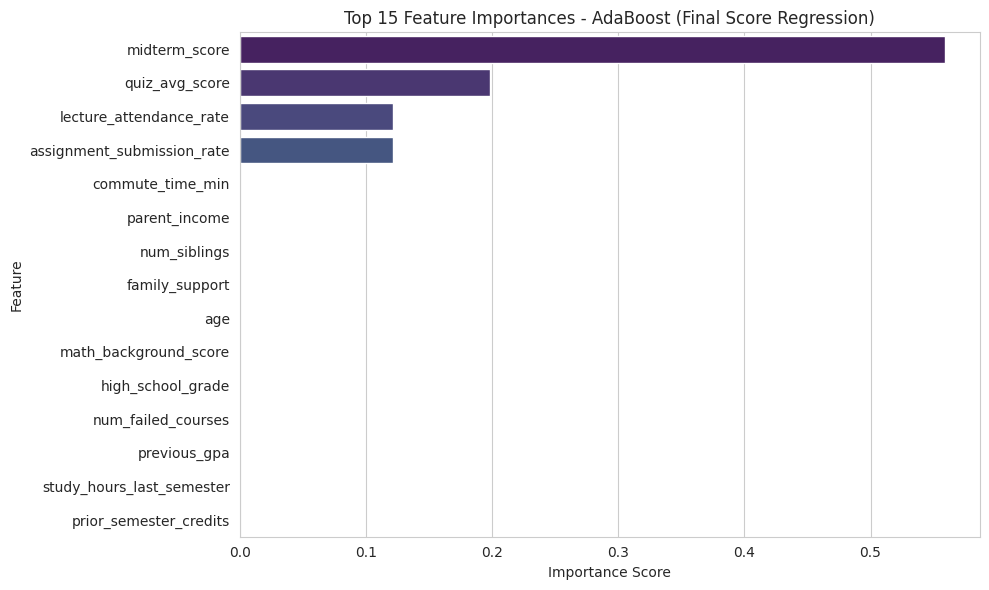

In [149]:
plot_feature_importance(ada_model, X_train.columns, "AdaBoost (Final Score Regression)")

Regression Metrics for final_score (Ridge):
MSE: 29.6619
MAE: 4.2649
R^2 Score: 0.7495


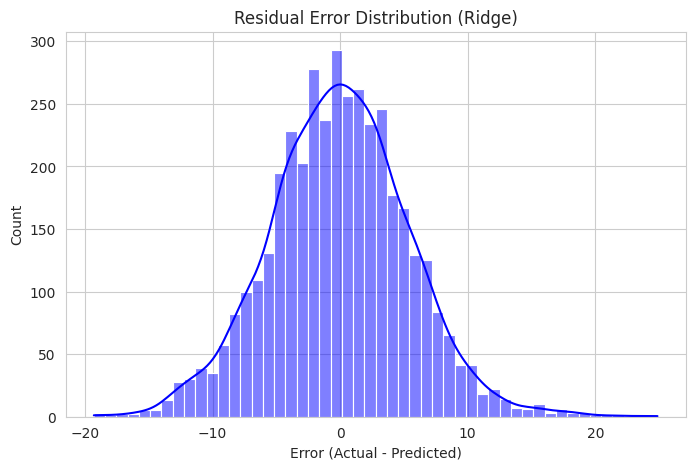

In [150]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train
# alpha is the regularization strength; larger values specify stronger regularization
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_reg_train)

# Predictions
y_ridge_pred = ridge_model.predict(X_test)

# Evaluation
print(f"Regression Metrics for final_score (Ridge):")
print(f"MSE: {mean_squared_error(y_reg_test, y_ridge_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_ridge_pred):.4f}")
print(f"R^2 Score: {r2_score(y_reg_test, y_ridge_pred):.4f}")

# Residual Error Plot
plt.figure(figsize=(8, 5))
residuals_ridge = y_reg_test - y_ridge_pred
sns.histplot(residuals_ridge, kde=True, color='blue')
plt.title('Residual Error Distribution (Ridge)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

Regression Metrics for final_score (Random Forest):
MSE: 32.2925
MAE: 4.4733
R^2 Score: 0.7272


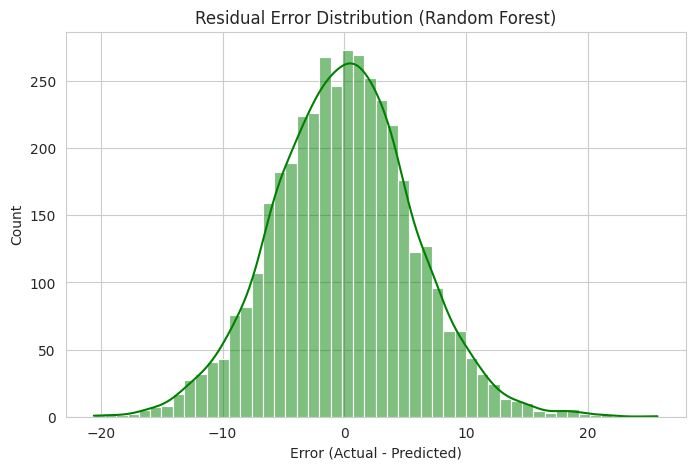

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_reg_train)

# Predictions
y_rf_pred = rf_model.predict(X_test)

# Evaluation
print(f"Regression Metrics for final_score (Random Forest):")
print(f"MSE: {mean_squared_error(y_reg_test, y_rf_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_rf_pred):.4f}")
print(f"R^2 Score: {r2_score(y_reg_test, y_rf_pred):.4f}")

# Residual Error Plot
plt.figure(figsize=(8, 5))
residuals_rf = y_reg_test - y_rf_pred
sns.histplot(residuals_rf, kde=True, color='green')
plt.title('Residual Error Distribution (Random Forest)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

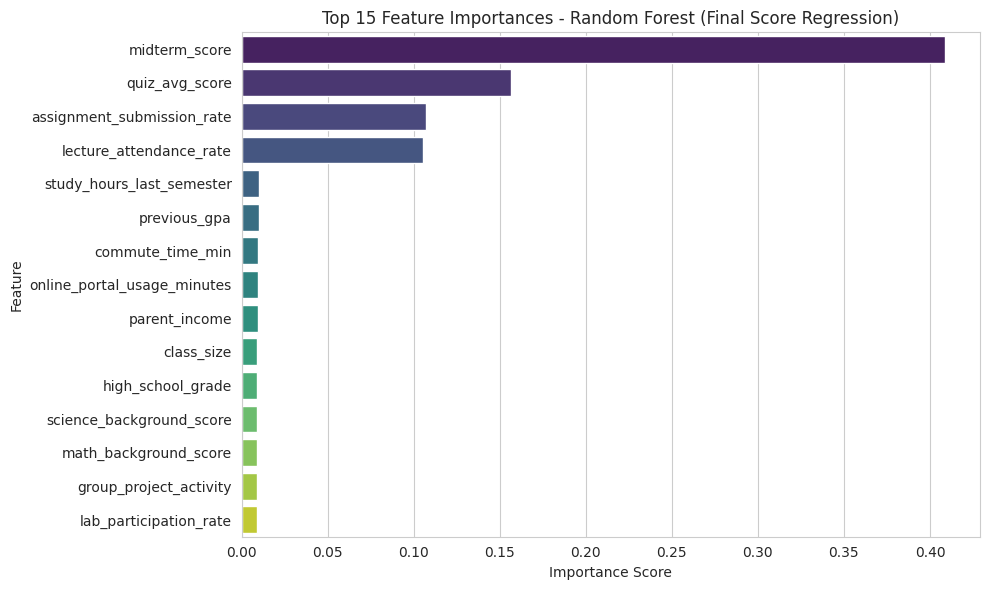

In [75]:
plot_feature_importance(rf_model, X_train.columns, "Random Forest (Final Score Regression)")

Regression Metrics for final_score (KNN):
MSE: 72.7928
MAE: 6.7623
R^2 Score: 0.3852


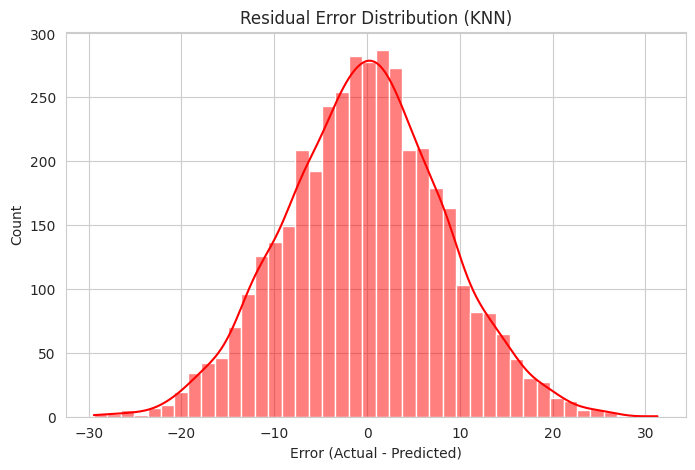

In [76]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_reg_train)

# Predictions
y_knn_pred = knn_model.predict(X_test)

# Evaluation
print(f"Regression Metrics for final_score (KNN):")
print(f"MSE: {mean_squared_error(y_reg_test, y_knn_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_knn_pred):.4f}")
print(f"R^2 Score: {r2_score(y_reg_test, y_knn_pred):.4f}")

# Residual Error Plot
plt.figure(figsize=(8, 5))
residuals_knn = y_reg_test - y_knn_pred
sns.histplot(residuals_knn, kde=True, color='red')
plt.title('Residual Error Distribution (KNN)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

/tmp/ipython-input-91681777.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MSE", data=metrics_df, ax=axes[0], palette="Blues_r")
/tmp/ipython-input-91681777.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MAE", data=metrics_df, ax=axes[1], palette="Greens_r")
/tmp/ipython-input-91681777.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2 Score", data=metrics_df, ax=axes[2], palette="Oranges_r")


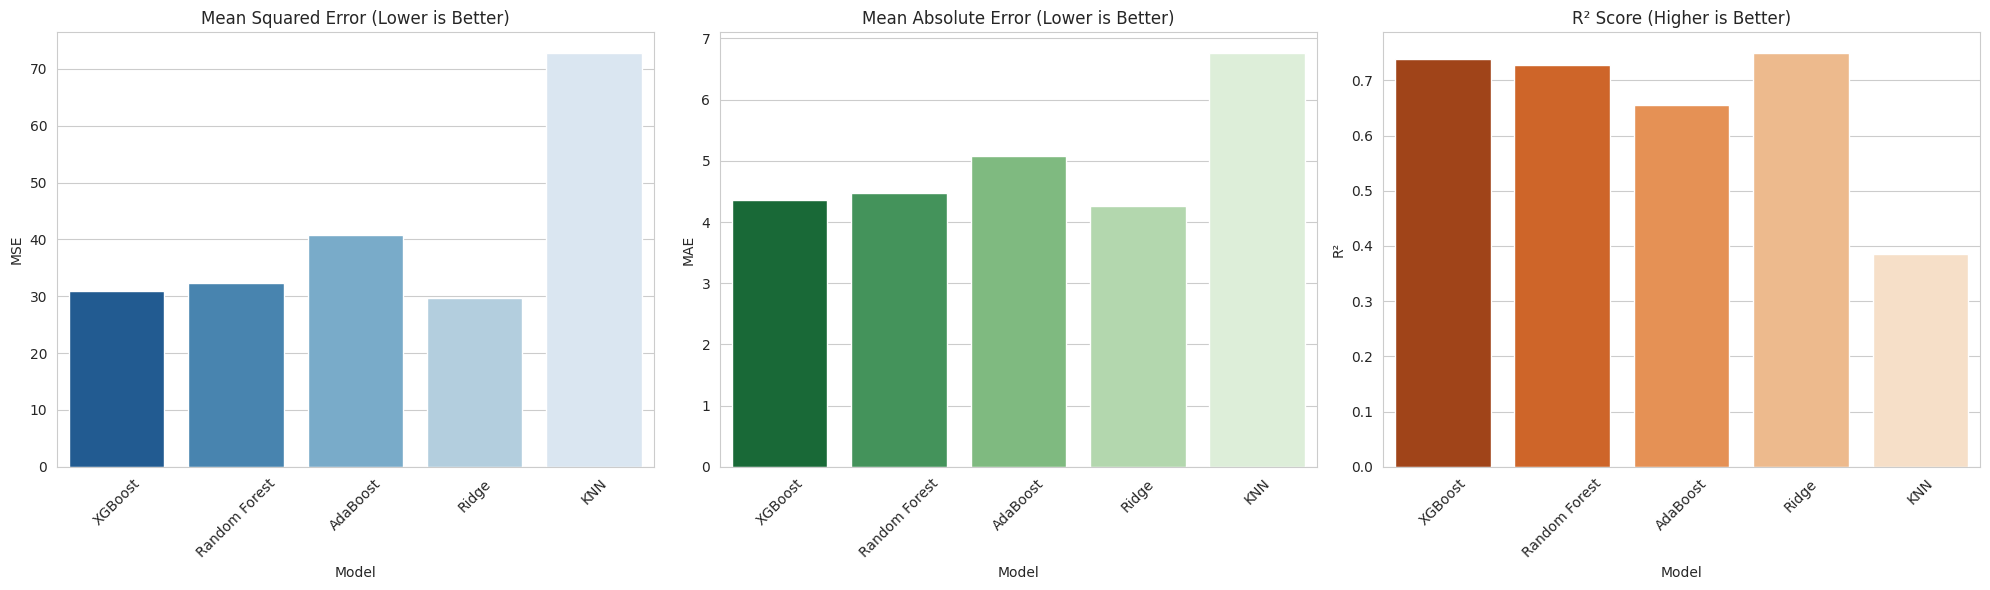


Model Performance Comparison:
           Model        MSE       MAE  R2 Score
3          Ridge  29.661882  4.264936  0.749460
0        XGBoost  30.953613  4.366828  0.738550
1  Random Forest  32.292475  4.473284  0.727241
2       AdaBoost  40.713994  5.086249  0.656109
4            KNN  72.792845  6.762275  0.385154


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Collect all predictions in a dictionary
# (Ensure you have run the previous cells so these variables exist)
model_predictions = {
    "XGBoost": y_reg_pred,
    "Random Forest": y_rf_pred,
    "AdaBoost": y_ada_pred,
    "Ridge": y_ridge_pred,
    "KNN": y_knn_pred
}

# 2. Calculate metrics for each model
results = []
for model_name, preds in model_predictions.items():
    mse = mean_squared_error(y_reg_test, preds)
    mae = mean_absolute_error(y_reg_test, preds)
    r2 = r2_score(y_reg_test, preds)
    results.append({
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# 3. Plotting the comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# MSE Plot (Lower is better)
sns.barplot(x="Model", y="MSE", data=metrics_df, ax=axes[0], palette="Blues_r")
axes[0].set_title("Mean Squared Error (Lower is Better)")
axes[0].set_ylabel("MSE")
axes[0].tick_params(axis='x', rotation=45)

# MAE Plot (Lower is better)
sns.barplot(x="Model", y="MAE", data=metrics_df, ax=axes[1], palette="Greens_r")
axes[1].set_title("Mean Absolute Error (Lower is Better)")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis='x', rotation=45)

# R2 Plot (Higher is better)
sns.barplot(x="Model", y="R2 Score", data=metrics_df, ax=axes[2], palette="Oranges_r")
axes[2].set_title("R² Score (Higher is Better)")
axes[2].set_ylabel("R²")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. Print the numeric table for reference
print("\nModel Performance Comparison:")
print(metrics_df.sort_values(by="R2 Score", ascending=False))